In [1]:
# Import packages

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
import glob
import matplotlib.patheffects as path_effects
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
import radlib
import os
import h5py
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter1d
from cartopy.feature import NaturalEarthFeature
import xmltodict, geopandas, geojson, xml #xml and json do not exist
from datetime import datetime, timedelta
import geopy.distance
from datetime import datetime, timedelta
import numpy.matlib as npm
import copy
from scipy.signal import convolve2d
from astropy.convolution import convolve
import scipy.ndimage as ndi
import re
from skimage.draw import polygon


from pprint import pprint
from pysteps import io, motion, rcparams
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

import json

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

os.environ["library_metranet_path"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyradlib
os.environ["METRANETLIB_PATH"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyart_mch




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Pysteps configuration file found at: /scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pysteps/pystepsrc



## Definitions

In [2]:
# Defining valid time and elevation scan

valid_time3 = '0925'
elevation_scan = '1'
radar_station = 'P'
radar_name = 'Plaine Morte'

In [3]:
# Data Imports, processing, norming, etc.

# Classify the GPSConverter for Cooridnate system transformation
class GPSConverter(object):
    '''
    GPS Converter class which is able to perform convertions between the 
    CH1903 and WGS84 system.
    '''
    # Convert CH y/x/h to WGS height
    def CHtoWGSheight(self, y, x, h):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        h = (h + 49.55) - (12.60 * y_aux) - (22.64 * x_aux)
        return h

    # Convert CH y/x to WGS lat
    def CHtoWGSlat(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lat = (16.9023892 + (3.238272 * x_aux)) + \
                - (0.270978 * pow(y_aux, 2)) + \
                - (0.002528 * pow(x_aux, 2)) + \
                - (0.0447 * pow(y_aux, 2) * x_aux) + \
                - (0.0140 * pow(x_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lat = (lat * 100) / 36
        return lat

    # Convert CH y/x to WGS long
    def CHtoWGSlng(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lng = (2.6779094 + (4.728982 * y_aux) + \
                + (0.791484 * y_aux * x_aux) + \
                + (0.1306 * y_aux * pow(x_aux, 2))) + \
                - (0.0436 * pow(y_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lng = (lng * 100) / 36
        return lng

    # Convert decimal angle (° dec) to sexagesimal angle (dd.mmss,ss)
    def DecToSexAngle(self, dec):
        degree = int(math.floor(dec))
        minute = int(math.floor((dec - degree) * 60))
        second = (((dec - degree) * 60) - minute) * 60
        return degree + (float(minute) / 100) + (second / 10000)
		
    # Convert sexagesimal angle (dd.mmss,ss) to seconds
    def SexAngleToSeconds(self, dms):
        degree = 0 
        minute = 0 
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return second + (minute * 60) + (degree * 3600)

    # Convert sexagesimal angle (dd.mmss) to decimal angle (degrees)
    def SexToDecAngle(self, dms):
        degree = 0
        minute = 0
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return degree + (minute / 60) + (second / 3600)
    
    # Convert WGS lat/long (° dec) and height to CH h
    def WGStoCHh(self, lat, lng, h):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        h = (h - 49.55) + (2.73 * lng_aux) + (6.94 * lat_aux)
        return h

    # Convert WGS lat/long (° dec) to CH x
    def WGStoCHx(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        x = ((200147.07 + (308807.95 * lat_aux) + \
            + (3745.25 * pow(lng_aux, 2)) + \
            + (76.63 * pow(lat_aux,2))) + \
            - (194.56 * pow(lng_aux, 2) * lat_aux)) + \
            + (119.79 * pow(lat_aux, 3))
        return x

	# Convert WGS lat/long (° dec) to CH y
    def WGStoCHy(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        y = (600072.37 + (211455.93 * lng_aux)) + \
            - (10938.51 * lng_aux * lat_aux) + \
            - (0.36 * lng_aux * pow(lat_aux, 2)) + \
            - (44.54 * pow(lng_aux, 3))
        return y

    def LV03toWGS84(self, east, north, height):
        '''
        Convert LV03 to WGS84 Return a array of double that contain lat, long,
        and height
        '''
        d = []
        d.append(self.CHtoWGSlat(east, north))
        d.append(self.CHtoWGSlng(east, north))
        d.append(self.CHtoWGSheight(east, north, height))
        return d
        
    def WGS84toLV03(self, latitude, longitude, ellHeight):
        '''
        Convert WGS84 to LV03 Return an array of double that contaign east,
        north, and height
        '''
        d = []
        d.append(self.WGStoCHy(latitude, longitude))
        d.append(self.WGStoCHx(latitude, longitude))
        d.append(self.WGStoCHh(latitude, longitude, ellHeight))
        return d
        
if __name__ == "__main__":
    ''' Example usage for the GPSConverter class.'''

    converter = GPSConverter()

    # Coordinates
    wgs84 = []
    lv03  = [567719, 155077, 1974]
    #567719/ 155077  Altitude: 1974
    # Convert WGS84 to LV03 coordinates
    wgs84 = converter.LV03toWGS84(lv03[0], lv03[1], lv03[2])

    print("WGS84: ")
    print(wgs84)
    print("LV03: ")
    print(lv03)

# Transform function for dealiased velocity
def transform_from_digital(mydata, nyquist):
    myfinaldata = (mydata * 1.0 - 128) * nyquist / 127
    myfinaldata[mydata == 0] = np.nan
    return myfinaldata

# Convert polar coordinates (range, azimuth) to geographic coordinates (lat/lon)
def radar_to_latlon(radar_lat, radar_lon, ranges, azimuths):
    R = 6371.0  # Earth radius in kilometers
    azimuths_rad = np.radians(azimuths)
    latitudes = np.zeros((len(azimuths), len(ranges)))
    longitudes = np.zeros((len(azimuths), len(ranges)))

    for i, az in enumerate(azimuths_rad):
        latitudes[i, :] = radar_lat + (ranges / R) * np.cos(az) * (180.0 / np.pi)
        longitudes[i, :] = radar_lon + (ranges / R) * np.sin(az) * (180.0 / np.pi) / np.cos(np.radians(radar_lat))

    return latitudes, longitudes

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=254000
    o_y=-159000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(geojson.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data=pd.read_csv(file).iloc[8:]
        headers=pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df=pd.DataFrame()
        for n in range(len(data)):
            t=data.iloc[n].str.split(';',expand=True)
            trt_df.loc[n,'traj_ID']=int(t[0].values)
            trt_df.loc[n,'time']=int(t[1].values)
            trt_df.loc[n,'lon']=t[2].values.astype(float)
            trt_df.loc[n,'lat']=t[3].values.astype(float)
            chx,chy=c_transform([trt_df.loc[n,'lon']],[trt_df.loc[n,'lat']])
            ix=np.round((chx-o_x)/1000).astype(int)
            if ix>=710: ix=709
            iy=np.round((chy-o_y)/1000).astype(int)
            if iy>=640: iy=639
            n2=27
            if int(ttime)>=221520631: n2=82
            tt=np.array(t)[0,n2:-1]
            tt=np.reshape(tt,[int(len(tt)/2),2])
            trt_df.loc[n,'chx']=chx
            trt_df.loc[n,'chy']=chy
            lat=tt[:,1].astype(float); lon=tt[:,0].astype(float)
            # trt_df=trt_df.astype(str)
            chx,chy=c_transform(lon,lat)
            ix=np.round((chx-o_x)/1000).astype(int)
            iy=np.round((chy-o_y)/1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr,cc]=int(t[0].values);
    # print(np.nanmax(cells))
    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define VAD reading function
def read_VAD(file_VAD):
    mydoc = xml.dom.minidom.parse(file_VAD)

    levels = mydoc.getElementsByTagName('level')
   
    heights = mydoc.getElementsByTagName('height')
    speeds = mydoc.getElementsByTagName('speed')
    directions = mydoc.getElementsByTagName('direction')
   
    vad_levels=np.zeros(len(levels))
    vad_heights=np.zeros(len(levels))
    vad_speeds=np.zeros(len(levels))
    vad_directions=np.zeros(len(levels))
    for m in range(0,len(levels)):
        vad_levels[m]=levels[m].firstChild.data
        vad_heights[m]=heights[m].firstChild.data
        vad_speeds[m]=speeds[m].firstChild.data
        vad_directions[m]=directions[m].firstChild.data
    vad_s=np.zeros(150); vad_d=np.zeros(150); vad_s[:]=np.nan; vad_d[:]=np.nan;
    for n in range(0,150):
        for m in range(0,len(levels)):
            if vad_levels[m]==n:
                vad_s[n]=vad_speeds[m]
                vad_d[n]=vad_directions[m]
       
       
    vad_u = np.multiply(vad_s, np.cos(np.radians(vad_d)))
    vad_v = np.multiply(vad_s, np.sin(np.radians(vad_d)))
   
    vadu=np.zeros(15); vadv=np.zeros(15);
    for n in range(0,15):
        a=n*10
        vadu[n]=np.nanmean(vad_u[a:a+10])
        vadv[n]=np.nanmean(vad_v[a:a+10])
       
    return vadu, vad_u, vadv, vad_v

# Function to calculate azimuth angle from radar to downburst location
def calculate_azimuth(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Calculate azimuth
    delta_lon = lon2 - lon1
    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)
    azimuth = math.atan2(x, y)
    azimuth_deg = math.degrees(azimuth)
    
    # Normalize to 0-360 degrees
    return (azimuth_deg + 360) % 360

# Convolves and normalizes 2D data with a 3x3 kernel
def conv(data):
    """
    Convolves and normalizes 2D data with a 3x3 kernel

    Parameters
    ----------
    data : 2-D array
        data to be convolved.

    Returns
    -------
    d_conv : 2-D array
        convolved data.

    """
    ## convolves 2D data with a 3x3 kernel, equal weights, wrapped boundary, NaN values ignored / filled in
    g_kernel=np.ones([3,3])/9
    d_conv=convolve(data,g_kernel, boundary='wrap')
    return d_conv

# azimuthal centered difference derivative for polar data -> wraps around 0/360
def az_cd(myfinaldata, nyquist, threshold, resolution, min_size):
    """
    azimuthal centered difference derivative for polar data -> wraps around 0/360

    Parameters
    ----------
    myfinaldata : 2D array
        input data.
    nyquist : float
        Nyquist velocity of raw velocity data.
    threshold : float
        shear correction threshold.
    resolution : float
        radial resolution of data.
    min_size : int
        minimum number of gates required for correction.

    Returns
    -------
    myshear_cor : 2D array
        azimuthal derivative, corrected for unfolding errors.
    mygateshear_cor : 2D array
        azimuthal difference (no normalization by distance), corrected for unfolding errors.

    """
    ## azimuthal derivative, centered difference
    ## corrects for anomalous shear exceeding threshold
    ## shear only corrected if contiguous area of several pixels
    myfinaldata_1=np.zeros(myfinaldata.shape)
    myfinaldata_1[:-1,:]=myfinaldata[1:,:]
    myfinaldata_1[-1,:]=myfinaldata[0,:]
    myfinaldata_2=np.zeros(myfinaldata.shape)
    myfinaldata_2[1:,:]=myfinaldata[:-1,:]
    myfinaldata_2[0,:]=myfinaldata[-1,:]
    
    distance=np.arange(0.5*resolution, myfinaldata.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,myfinaldata.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)
    
    myshear_1=(myfinaldata-myfinaldata_1)/(2*distance)*-(1)
    myshear_2=(myfinaldata_2-myfinaldata)/(2*distance)*(-1)
    myshear_3=(myfinaldata_2-myfinaldata_1)/(2*distance)*(-1)
    
    myshear_1_cor=shear_cor(myshear_1, distance, threshold, nyquist, min_size)
        
    myshear_2_cor=shear_cor(myshear_2, distance, threshold, nyquist, min_size)

    myshear_3_cor=shear_cor(myshear_3, distance, threshold, nyquist, min_size)
    
    myshear_cor=np.nansum([myshear_2_cor,myshear_1_cor],axis=0)
    myshear_cor[np.isnan(myfinaldata)==1]=myshear_3_cor[np.isnan(myfinaldata)==1]
    mygateshear_cor=myshear_cor*distance
    
    return myshear_cor, mygateshear_cor

# Identifies unfolding errors in derivative and corrects for them
def shear_cor(myshear, distance, threshold, nyquist, min_size):
    """
    Identifies unfolding errors in derivative and corrects for them

    Parameters
    ----------
    myshear : 2D array
        input data.
    distance : 2D array
        azimuthal Cartesian distance between gates.
    threshold : float
        error identification threshold.
    nyquist : float
        correction interval (nyquist velocity).
    min_size : int
        minimum number of connected erroneous gates.

    Returns
    -------
    myshear_cor : 2D array
        corrected data.

    """
    ## function embedded in centered difference shear
    ## eliminates anomalous shear in contiguous area
    myshear_cor=(myshear*(2*distance))
    thresh_1=(myshear*(2*distance))-threshold
    thresh_2=(myshear*(2*distance))+threshold
    
    mybin_pos=np.zeros(myshear.shape)
    mybin_pos[thresh_1>=0]=1
    labels, n_groups=ndi.label(mybin_pos)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] -= (2*nyquist)
    
    mybin_neg=np.zeros(myshear.shape)
    mybin_neg[thresh_2<=0]=1
    labels, n_groups=ndi.label(mybin_neg)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] += (2*nyquist)
    myshear_cor=myshear_cor/(2*distance)
    return myshear_cor

# azimuthal linear least squares derivative        
def az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    azimuthal linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    az_shear : array of same dimensions as data
        azimuthal derivative of data.

    """
    ##azimuthal linear least squares derivative
    az_shear=( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k_thet * ( - np.sum(weights * d_r * d_r) * np.sum(weights) + np.sum(weights * d_r) * np.sum(weights * d_r)) \
                + u_k * (np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) - np.sum(weights * d_r) * np.sum(weights * d_r * d_theta)) )
    return az_shear

# radial linear least squares derivative
def div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    radial linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    div_shear : array of same dimensions as data
        radial derivative of data.

    """
    ##radial linear least squares derivative
    div_shear= ( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (- np.sum(weights * d_theta * d_theta) * np.sum(weights) + np.sum(weights * d_theta) * np.sum(weights * d_theta)) \
                + u_k_thet * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k * ( - np.sum(weights * d_r * d_theta) * np.sum(weights * d_theta) + np.sum(weights * d_r) * np.sum(weights * d_theta * d_theta)) )
    return div_shear

# full linear least squares derivative
def llsd(vel, az_min, az_max, w_k, r_k, resolution):
    """
    full linear least squares derivative

    Parameters
    ----------
    vel : 2D array
        input data, polar data.
    az_min : int
        min. number of gates in azimuth.
    az_max : int
        max. number of gates in azimuth.
    w_k : float
        kernel width in azimuth (Cartesian).
    r_k : float
        kernel width in radial (Cartesian).
    resolution : float
        radial resolution.

    Returns
    -------
    az_shear : 2D array
        azimuthal derivative.
    div_shear : 2D array
        radial derivative.

    """
    ##complete linear least squares derivative
    az_shear=np.zeros(vel.shape); az_shear[:]=np.nan
    div_shear=np.zeros(vel.shape); div_shear[:]=np.nan
    
    distance=np.arange(0.5*resolution, vel.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,vel.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)

    r_h=int(np.floor(az_max/2))
	
    for n2 in range(r_h,vel.shape[1]-r_h):
        
        az_w=int(np.round(w_k/distance[1,n2]));
        if az_w%2 == 0: az_w+=1
        if az_w>az_max: az_w=az_max
        if az_w<az_min: az_w=az_min
        az_r=int(np.floor(az_w/2))
        
        r_w= r_k/resolution;
        if r_w%2 == 0: r_w+=1
        r_w=int(r_w)
        r_r=r_w*resolution
        r_vec=np.arange(-r_r,r_r+resolution,resolution)
        r_vec=np.expand_dims(r_vec,axis=0)
        d_r=np.repeat(r_vec,az_w,axis=0)
        
        d_r=np.zeros([az_w,r_w])
        for n2_2 in range(0,r_w):
            d_r[:,n2_2]=-r_k*n2_2/(r_w-1)+r_k*0.5
        rw_f=int(np.floor(r_w/2))
	    
        d_r2=-copy.deepcopy(d_r); #print(d_r.shape,n2)
        weights=np.ones([az_w,r_w])
        d_theta=copy.deepcopy(distance[:az_w,n2-rw_f:n2+rw_f+1]); d_theta[az_r,:]=0
        d_theta[:az_r,:]=-d_theta[:az_r,:];
        d_thet=copy.deepcopy(d_theta); d_thet=-np.flip(d_thet,1)

        u_k=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],weights,mode='same',boundary='wrap')[:,1]
        u_k_thet=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_thet,mode='same',boundary='wrap')[:,1]
        u_k_r=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_r2,mode='same',boundary='wrap')[:,1]

        az_shear[:,n2]= az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
        div_shear[:,n2]= div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
    return az_shear, div_shear

# c_transform
def c_transform(lon,lat):
    """
    transforms arrays of lat/lon to chx/chy

    Parameters
    ----------
    lon : float
        longitude.
    lat : float
        latitude.

    Returns
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.

    """
    converter = GPSConverter()
    chx=np.zeros([len(lon)])
    chy=np.zeros([len(lon)])
    for n in range(len(lon)):
        chx[n],chy[n],z=converter.WGS84toLV03(lat[n], lon[n], 0)
    return chx,chy

# transform_c 
def transform_c(chx,chy):
    """
    transforms arrays of chx/chy to lat/lon
    
    Parameters
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.
        
    Returns
    ----------
    lon : float
        longitude.
    lat : float
        latitude.



    """
    converter = GPSConverter()
    lon=np.zeros([len(chx)])
    lat=np.zeros([len(chy)])
    for n in range(len(lon)):
        lat[n], lon[n],z=converter.LV03toWGS84(chx[n],chy[n], 0)
    return lon,lat



# Radar locations
if radar_station=='L':
    radar_lat = 46.0401
    radar_lon = 8.8334
    radar_alt = 1627 
if radar_station=='P':
    radar_lat = 46.37083
    radar_lon = 7.48694
    radar_alt = 2927
if radar_station=='W':
    radar_lat = 46.832
    radar_lon = 9.796
    radar_alt = 2892 
if radar_station=='A':
    radar_lat = 47.2841
    radar_lon = 8.5117
    radar_alt = 938 
if radar_station=='D':
    radar_lat = 46.425676
    radar_lon = 6.100092
    radar_alt = 1670


# Coordinates of cities Zürich: 47.3769° N, 8.5417° E, Winterthur: 47.4980° N, 8.7241° E, St. Gallen: 47.4239° N, 9.3748° E
LaChauxDeFonds_lat = 47.10278
LaChauxDeFonds_lon = 6.83
LeLocle_lat = 47.05694
LeLocle_lon = 6.74861

# Load radar data
path = '/scratch/mch/fackerma/orders/case_240723'
file = glob.glob(path + '/ML/ML' + radar_station + '23205' + valid_time3 + '0U.00' + elevation_scan) # ML data 
file2 = glob.glob(path +'/DVA/srn/data/tmp/mof/DV' + radar_station + '/DV' + radar_station + '23205' + valid_time3 + '7L.80' + elevation_scan) # Dealiased velocity
file3 = glob.glob(path +'/HZC/HZC23205' + valid_time3 + 'VL.801') # Freezing level height composite
#file4 = glob.glob(path +'/VAA/VA' + radar_station + '23236' + valid_time3 + '7U.019') # Vertical wind profile above radar
file5 = glob.glob(path +'/BZC/BZC23205' + valid_time3 + 'VL.845') # POH
file6 = glob.glob(path +'/MZC/MZC23205' + valid_time3 + 'VL.850') # MESH
file7 = glob.glob(path +'/TRTC/CZC23205' + valid_time3 + '0T.rdt') # Thunderstorm radar tracking; or .rdt .trt
file8 = glob.glob(path +'/CZC/CZC23205' + valid_time3 + 'VL.801') # Reflectivity composite
file9 = glob.glob(path +'/LZC/LZC23205' + valid_time3 + 'VL.801') # VIL composite
file10 = glob.glob(path +'/EZC/EZC23205' + valid_time3 + 'VL.820') # Echotops composite: 815, 820, 845, 850
file11 = glob.glob(path +'/OZC/OZC23205' + valid_time3 + 'VL.830') # CAPPI composite, ranging from 810 to 980 in steps of 10
file12 = glob.glob(path + '/dARC/ARC232050000FF.1440') # daily bias corrected rain accumulation
file13 = glob.glob(path + '/dBZC/BZC232052400VL.845') # daily POH
file14 = glob.glob(path + '/dRZC/RZC232052400VL.001') # daily Rain Rate
file15 = glob.glob(path + '/dCZC/CZC232052400VL.801') # daily Max Echo


# Read the data for the plots
data = pyart.aux_io.read_metranet(file[0], reader='python')
velocity = data.get_field(0, 'velocity').data
reflectivity = data.get_field(0, 'reflectivity').data

dv_data = pyart.aux_io.read_file_py(file2[0], physic_value=False)
dv_digital = dv_data.data
dv_header = dv_data.header
nyq = float(dv_header['nyquist'])
dv_velocity = transform_from_digital(dv_digital, nyq)

hzc_data = radlib.read_file(file3[0],physic_value=True)
hzc=hzc_data.data

dARC_data = radlib.read_file(file12[0],physic_value=True)
dARC=dARC_data.data

dBZC_data = radlib.read_file(file13[0],physic_value=True)
dBZC=dBZC_data.data

dRZC_data = radlib.read_file(file14[0],physic_value=True)
dRZC=dRZC_data.data

dCZC_data = radlib.read_file(file15[0],physic_value=True)
dCZC=dCZC_data.data

diff_reflectivity = data.get_field(0, 'differential_reflectivity').data

diff_phase = data.get_field(0, 'uncorrected_differential_phase').data

cc_ratio = data.get_field(0, 'uncorrected_cross_correlation_ratio').data

mzc_data = radlib.read_file(file6[0],physic_value=True)
mzc=mzc_data.data

bzc_data = radlib.read_file(file5[0],physic_value=True)
bzc=bzc_data.data

specw = data.get_field(0, 'spectrum_width').data

czc_data = radlib.read_file(file8[0],physic_value=True)
czc=czc_data.data

lzc_data = radlib.read_file(file9[0],physic_value=True)
lzc=lzc_data.data

ezc_data = radlib.read_file(file10[0],physic_value=True)
ezc=ezc_data.data

ozc_data = radlib.read_file(file11[0],physic_value=True)
ozc=ozc_data.data

valid_time4 = valid_time3 + '0'
path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/case_240723/"}  # Replace with your actual path
trt_df, cells_list, timelist = read_TRT(path_trtc, ttime=valid_time4)
# Extract the first element from the list of cells
cells = cells_list[0]
# Define Swiss CH1903 to WGS84 transformer
transformer_trtc = Transformer.from_crs("epsg:21781", "epsg:4326", always_xy=True)
# Grid dimensions and origin
o_x, o_y = 255000, -160000  # Origin in Swiss coordinates
lx, ly = 710, 640           # Grid size (width x height)
cell_size = 1000            # 1 km grid spacing
# Create Swiss grid (CH1903 coordinates)
x_coords = np.linspace(o_x, o_x + (lx - 1) * cell_size, lx)
y_coords = np.linspace(o_y, o_y + (ly - 1) * cell_size, ly)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
# Convert grid to WGS84 (longitude, latitude)
lon_trtc, lat_trtc = transformer_trtc.transform(x_grid, y_grid)


#vad = read_VAD(file4[0])

# Convert echotop18 from km to meters
ezc_m = ezc * 1000
# Compute the wind gust estimator 'wge' (Trefalt 2017)
wge = np.sqrt((-3.1 * 10**-6 * (ezc**2)) + (20.6 * lzc))


resolution = 0.5
range_max = reflectivity.shape[1] * resolution
azimuths = np.linspace(0, 360, reflectivity.shape[0])
ranges = np.arange(0, range_max, resolution)

# Own KDP calculation
#smoothed_diff_phase = gaussian_filter1d(diff_phase, sigma=2, axis=1) 
#Kdp = np.gradient(smoothed_diff_phase, ranges, axis=1)

# KDP Vulpiani Method
Kdp = pyart.retrieve.kdp_vulpiani(data, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
Kdp = Kdp[0]['data']

# Radial llsd_vel[1] and azimuthal llsd_vel[0] shear
llsd_vel = llsd(vel=dv_velocity, az_min=3, az_max=90, w_k=5, r_k=5, resolution=0.5)





# Transform radar polar coordinates to lat/lon
lats, lons = radar_to_latlon(radar_lat, radar_lon, ranges, azimuths)

# Define the Swiss grid (values based on metadata)
chx = np.arange(255000, 255000 + 710 * 1000 + 1, 1000)
chy = sorted(np.arange(-160000, -160000 + 640 * 1000 + 1, 1000), reverse=True)
X, Y = np.meshgrid(chx, chy)
# Initialize transformer for Swiss grid 
transformer = Transformer.from_crs(21781, 3035, always_xy=True)

#lons,lats = transformer.transform(X, Y)
clons, clats = transformer.transform(X, Y)
#lons, lats = transformer.transform(X, Y)

cmap_czc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "blue", "green", "yellow","red","magenta","black"], N=256)
czc_levels = np.arange(-10, 65, 5)  # Steps of 2 for Reflectivity
czc_norm = BoundaryNorm(boundaries=czc_levels, ncolors=256, clip=True)
# Define color steps for Reflectivity and Velocity/Dealiased Velocity
reflectivity_levels = np.arange(-5, 65, 5)  # Steps of 2 for Reflectivity
velocity_levels = np.arange(-25, 26, 5)  # Steps of 1 for Velocity and Dealiased Velocity
hzc_levels = np.arange(1, 10, 1)
diff_reflectivity_levels = np.arange(-1,3.5,0.5)
diff_phase_levels = np.arange(-70,90,20)
cc_ratio_levels = np.arange(0.7,1,0.05)
mzc_levels = np.arange(0,5.5,0.5)
bzc_levels = np.arange(0,101,10)
specw_levels = np.arange(0,7,1)
Kdp_levels = np.arange(0,5.5,0.5)
lzc_levels = np.arange(2.5,25,2.5)
ezc_levels = np.arange(2,16,2)
wge_levels = np.arange(4,24,2)
az_shear_levels = np.arange(-5, 5.5, 1)
div_shear_levels = np.arange(-5, 5.5, 1)
# Create boundary norms

reflectivity_norm = BoundaryNorm(boundaries=reflectivity_levels, ncolors=plt.cm.inferno.N, clip=True)
velocity_norm = BoundaryNorm(boundaries=velocity_levels, ncolors=256, clip=True)
hzc_norm = BoundaryNorm(boundaries=hzc_levels, ncolors=256, clip=True)
diff_reflectivity_norm = BoundaryNorm(boundaries=diff_reflectivity_levels, ncolors=256, clip=True)
diff_phase_norm = BoundaryNorm(boundaries=diff_phase_levels, ncolors=256, clip=True)
cc_ratio_norm = BoundaryNorm(boundaries=cc_ratio_levels, ncolors=256, clip=True)
mzc_norm = BoundaryNorm(boundaries=mzc_levels, ncolors=256, clip=True)
bzc_norm = BoundaryNorm(boundaries=bzc_levels, ncolors=256, clip=True)
specw_norm = BoundaryNorm(boundaries=specw_levels, ncolors=256, clip=True)
Kdp_norm = BoundaryNorm(boundaries=Kdp_levels, ncolors=256, clip=True)
lzc_norm = BoundaryNorm(boundaries=lzc_levels, ncolors=256, clip=True)
ezc_norm = BoundaryNorm(boundaries=ezc_levels, ncolors=256, clip=True)
wge_norm = BoundaryNorm(boundaries=wge_levels, ncolors=256, clip=True)
az_shear_norm = BoundaryNorm(boundaries=az_shear_levels, ncolors=256, clip=True)
div_shear_norm = BoundaryNorm(boundaries=div_shear_levels, ncolors=256, clip=True)


cmap_velocity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"], N=256)
cmap_hzc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "dodgerblue", "midnightblue"], N=256)
cmap_diff_reflectivity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_phase = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_cc_ratio = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_Kdp = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_bzc = LinearSegmentedColormap.from_list("custom_cmap", ["black","yellow", "red"], N=256)
cmap_specw = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_lzc = LinearSegmentedColormap.from_list("custom_cmap", ["black", "cyan", "purple"], N=256)
cmap_ezc = plt.cm.Blues
cmap_wge = LinearSegmentedColormap.from_list("custom_cmap", ["white", "cyan", "blue", "darkblue"], N=256)
cmap_vad = plt.cm.Accent
cmap_az_shear = LinearSegmentedColormap.from_list("custom_cmap", ["aqua","blue", "black", "red","yellow"], N=256)
cmap_div_shear = cmap_az_shear




# Assess rhi files
files_rhi = sorted(glob.glob(path + '/MLA/MLP23205' + valid_time3 + '*')) # Read all elevations for rhi
for i,f in enumerate(files_rhi):
    radar = pyart.aux_io.read_metranet(f)
    
    if i == 0:
        radar_merged = radar
    else:
        radar_merged = pyart.util.join_radar(radar_merged, 
                                       radar)
#corr_vel = pyart.correct.dealias_region_based(radar_merged)
#radar_merged.add_field('corrected_velocity', corr_vel)

# Crowd-sourcing data path
file_cs = '/scratch/mch/fackerma/orders/case_240723/wind_reports_2023_07_24.json'


# Extents for plotting
extent_switzerland = [5.77, 10.8, 45.5, 48]
max_extent = [4, 12, 44, 49]
WestSwitzrelandLarge_extent = [4.1, 8.8, 45.8, 48]

WGS84: 
[46.54620053012867, 7.017760746224894, 2024.97379732]
LV03: 
[567719, 155077, 1974]
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
read_rdp_product expand error: 454400 <=> 1817600
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
swap product table data ......
py_decoder DBG verb=0
py_decoder DBG verbl=0


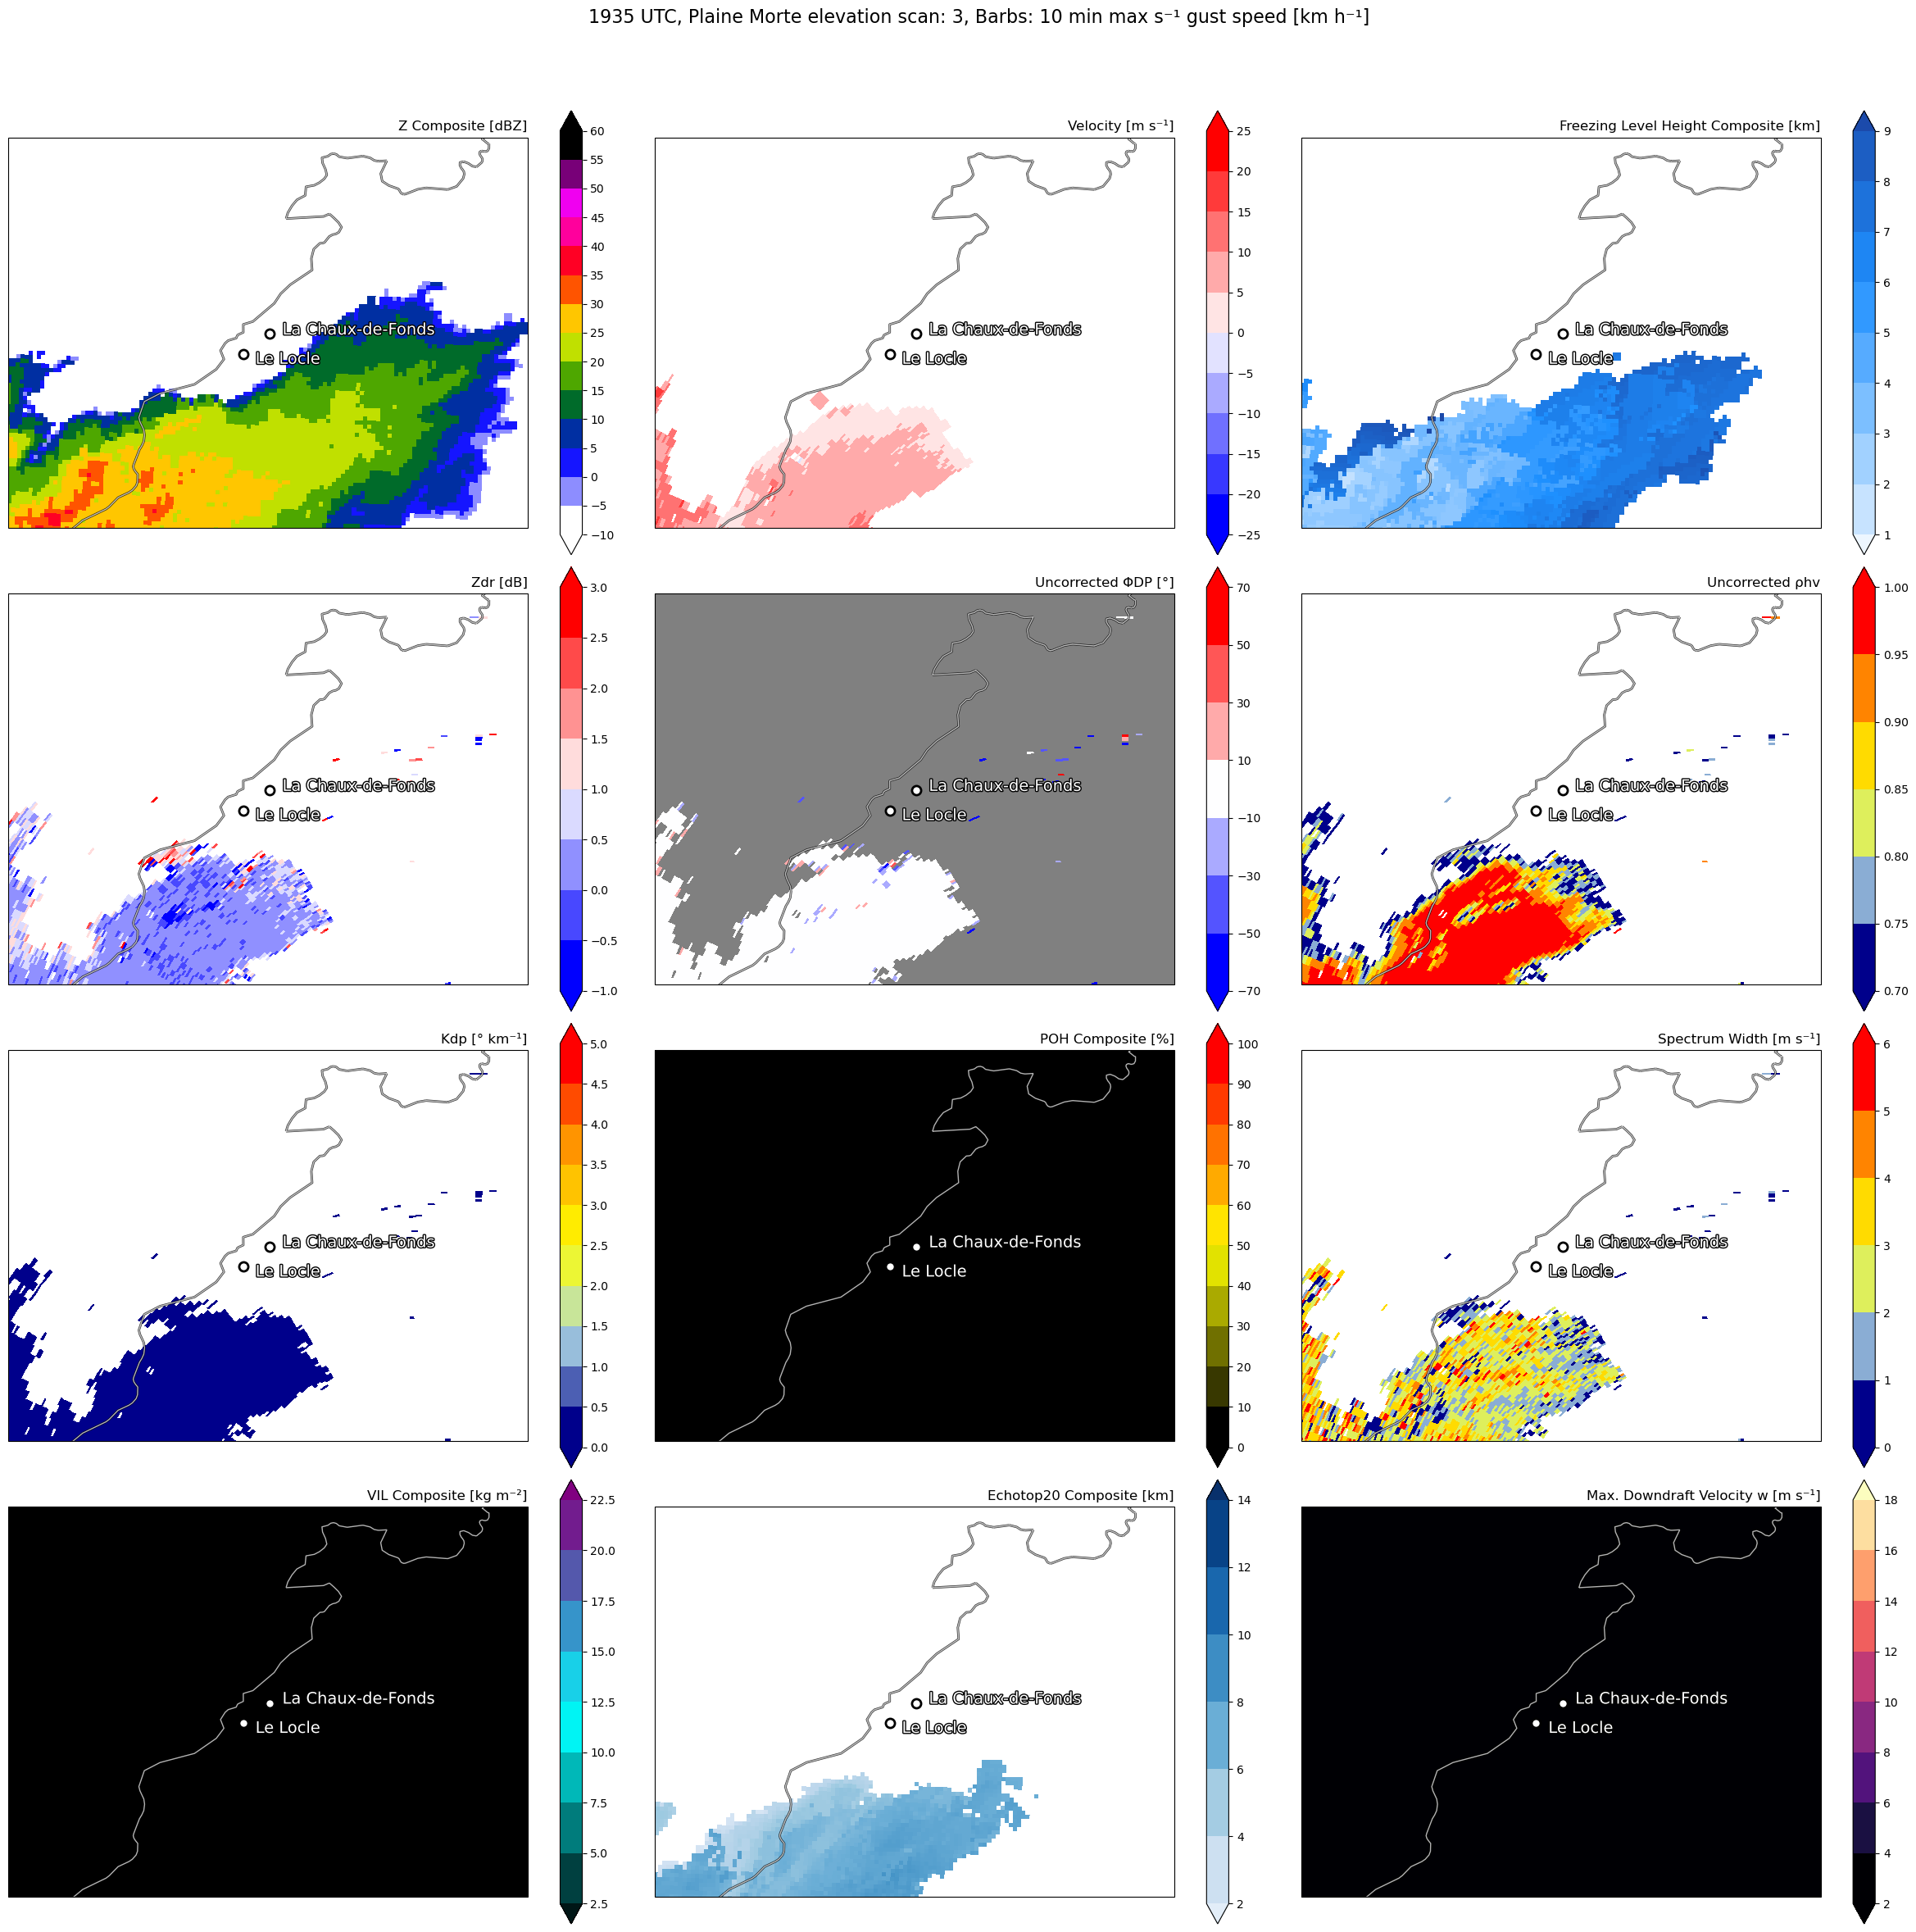

In [13]:
# Multi-variable plot
projection = ccrs.epsg(3035)
# Create figure with three subplots (Reflectivity, Velocity, and Dealiased Velocity)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24,24), subplot_kw={'projection': projection})

# Set background to black for all subplots
for row in axs:  # axs is a 2D array, so iterate through rows
    for ax in row:  # Iterate through each subplot in the row
        fig.patch.set_facecolor('white')  # Set figure background
        ax.set_facecolor('white')  # Set axis background
edgecolor='black'

# Plot Reflectivity composite
cmap_czc.set_bad(color='white')
p1 = axs[0,0].pcolormesh(clons, clats, czc, norm=czc_norm,
                   cmap=cmap_czc, transform=projection)
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=axs[0,0], extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor(edgecolor)
cbar1.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color=edgecolor)
axs[0,0].set_title('Z Composite [dBZ]', color=edgecolor, loc='right')


# Plot Dealiased Velocity
cmap_velocity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"], N=256)
cmap_velocity.set_bad(color='white')
# Assuming lons and lats are 1D arrays
p2 = axs[0,1].pcolormesh(lons, lats, dv_velocity, cmap=cmap_velocity, norm=velocity_norm, transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(p2, ax=axs[0,1], cmap=cmap_velocity, extend='both', boundaries=velocity_levels, ticks=velocity_levels)
cbar2.outline.set_edgecolor(edgecolor)
cbar2.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color=edgecolor)
axs[0,1].set_title('Velocity [m s⁻¹]', color=edgecolor, loc='right')


# Plot Freezing level height
# Mask values of freezing level height that are 0 or lower
hzc_masked = np.ma.masked_less_equal(hzc, 0)
# Define a custom colormap, setting the under value (for masked/low values) to black
cmap_hzc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "dodgerblue", "midnightblue"], N=256)
#cmap_hzc.set_under('black')  # Black for values 0 or lower
cmap_hzc.set_bad(color='white')  # Black for invalid data
# Plot the freezing level height with the masked values
p3 = axs[0,2].pcolormesh(clons, clats, hzc_masked, vmin=0, vmax=12, 
                         cmap=cmap_hzc, transform=projection)
# Add a colorbar
cbar3 = plt.colorbar(p3, ax=axs[0,2], extend='both', cmap=cmap_hzc, boundaries=hzc_levels, ticks=hzc_levels)
cbar3.outline.set_edgecolor(edgecolor)
cbar3.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar3.ax.axes, 'yticklabels'), color=edgecolor)
axs[0,2].set_title('Freezing Level Height Composite [km]', color=edgecolor, loc='right')


# Plot Differential Reflectivity
cmap_diff_reflectivity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_reflectivity.set_bad(color='white')
p4 = axs[1,0].pcolormesh(lons, lats, diff_reflectivity, cmap=cmap_diff_reflectivity, norm=diff_reflectivity_norm, 
                         transform=ccrs.PlateCarree())
cbar4 = plt.colorbar(p4, ax=axs[1,0], cmap=cmap_diff_reflectivity, extend='both', boundaries=diff_reflectivity_levels, ticks=diff_reflectivity_levels
                     )
cbar4.outline.set_edgecolor(edgecolor)
cbar4.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar4.ax.axes, 'yticklabels'), color=edgecolor)
axs[1,0].set_title('Zdr [dB]', color=edgecolor, loc='right')


# Plot Differential Phase
cmap_diff_phase = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_phase.set_bad(color='grey')
p5 = axs[1,1].pcolormesh(lons, lats, diff_phase, cmap=cmap_diff_phase, norm=diff_phase_norm, 
                         transform=ccrs.PlateCarree())
cbar5 = plt.colorbar(p5, ax=axs[1,1], cmap=cmap_diff_phase, extend='both', boundaries=diff_phase_levels, ticks=diff_phase_levels
                     )
cbar5.outline.set_edgecolor(edgecolor)
cbar5.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar5.ax.axes, 'yticklabels'), color=edgecolor)
axs[1,1].set_title('Uncorrected ΦDP [°]', color=edgecolor, loc='right')


# Plot CC ratio
cmap_cc_ratio = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_cc_ratio.set_bad(color='white')
p6 = axs[1,2].pcolormesh(lons, lats, cc_ratio, cmap=cmap_cc_ratio, norm=cc_ratio_norm, 
                         transform=ccrs.PlateCarree())
cbar6 = plt.colorbar(p6, ax=axs[1,2], cmap=cmap_cc_ratio, extend='both', boundaries=cc_ratio_levels, ticks=cc_ratio_levels
                     )
cbar6.outline.set_edgecolor(edgecolor)
cbar6.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar6.ax.axes, 'yticklabels'), color=edgecolor)
axs[1,2].set_title('Uncorrected ρhv', color=edgecolor, loc='right')


# Plot Kdp
cmap_Kdp = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_Kdp.set_bad(color='white')
p7 = axs[2,0].pcolormesh(lons, lats, Kdp, norm=Kdp_norm,
                   cmap=cmap_Kdp, transform=ccrs.PlateCarree())
# Add a colorbar
cbar7 = plt.colorbar(p7, ax=axs[2,0], extend='both', cmap=cmap_Kdp, boundaries=Kdp_levels, ticks=Kdp_levels
                     )
cbar7.outline.set_edgecolor(edgecolor)
cbar7.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar7.ax.axes, 'yticklabels'), color=edgecolor)
axs[2,0].set_title('Kdp [° km⁻¹]', color=edgecolor, loc='right')


# Plot POH
cmap_bzc = LinearSegmentedColormap.from_list("custom_cmap", ["black","yellow", "red"], N=256)
cmap_bzc.set_bad(color='white')
p8 = axs[2,1].pcolormesh(clons, clats, bzc, norm=bzc_norm,
                   cmap=cmap_bzc, transform=projection)
# Add a colorbar
cbar8 = plt.colorbar(p8, ax=axs[2,1], extend='both', cmap=cmap_bzc, boundaries=bzc_levels, ticks=bzc_levels
                     )
cbar8.outline.set_edgecolor(edgecolor)
cbar8.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar8.ax.axes, 'yticklabels'), color=edgecolor)
axs[2,1].set_title('POH Composite [%]', color=edgecolor, loc='right')


# Plot Spectrum Width
cmap_specw = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_specw.set_bad(color='white')
p9 = axs[2,2].pcolormesh(lons, lats, specw, cmap=cmap_specw, norm=specw_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[2,2], cmap=cmap_specw, extend='both', boundaries=specw_levels, ticks=specw_levels
                     )
cbar9.outline.set_edgecolor(edgecolor)
cbar9.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color=edgecolor)
axs[2,2].set_title('Spectrum Width [m s⁻¹]', color=edgecolor, loc='right')

# Plot VIL composite
#lzc = np.ma.masked_less_equal(lzc, 0.1)
cmap_lzc = LinearSegmentedColormap.from_list("custom_cmap", ["black", "cyan", "purple"#, "red"
                                                             ], N=256)
cmap_lzc.set_bad(color='white')
p10 = axs[3,0].pcolormesh(clons, clats, lzc, vmin=1, vmax=22.5, 
                   cmap=cmap_lzc, transform=projection)
# Add a colorbar
cbar10 = plt.colorbar(p10, ax=axs[3,0], extend='both', cmap=cmap_lzc, norm=lzc_norm, boundaries=lzc_levels, ticks=lzc_levels
                     )
cbar10.outline.set_edgecolor(edgecolor)
cbar10.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar10.ax.axes, 'yticklabels'), color=edgecolor)
axs[3,0].set_title('VIL Composite [kg m⁻²]', color=edgecolor, loc='right')

# Plot Echotop 20 composite
# Set a mask
ezc = np.ma.masked_less_equal(ezc, 0)
cmap_ezc = plt.cm.Blues
cmap_ezc.set_bad(color='white')
p11 = axs[3,1].pcolormesh(clons, clats, ezc, vmin=0, vmax=14,  
                   cmap=cmap_ezc, transform=projection)
# Add a colorbar
cbar11 = plt.colorbar(p11, ax=axs[3,1], extend='both', cmap=cmap_ezc, norm=ezc_norm, boundaries=ezc_levels, ticks=ezc_levels
                     )
cbar11.outline.set_edgecolor(edgecolor)
cbar11.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar11.ax.axes, 'yticklabels'), color=edgecolor)
axs[3,1].set_title('Echotop20 Composite [km]', color=edgecolor, loc='right')

# Plot wge composite
# Set a mask
wge = np.ma.masked_less_equal(wge, 0)
cmap_wge = plt.cm.magma
cmap_wge.set_bad(color='white')
p12 = axs[3,2].pcolormesh(clons, clats, wge, vmax=18, 
                   cmap=cmap_wge, transform=projection)
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=axs[3,2], extend='both', cmap=cmap_wge, norm=wge_norm, boundaries=wge_levels, ticks=wge_levels
                     )
cbar12.outline.set_edgecolor(edgecolor)
cbar12.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color=edgecolor)
axs[3,2].set_title('Max. Downdraft Velocity w [m s⁻¹]', color=edgecolor, loc='right')

# (Plotting of wind barbs and other features remains the same)
# Add Radar, Geneva, and Lausanne locations to all plots
for row in axs:
    for ax in row:
            #ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree())  # Radar location
        ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree(),
        path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
        ax.plot(LaChauxDeFonds_lon, LaChauxDeFonds_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree()) 
        ax.plot(LeLocle_lon, LeLocle_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree()) 
        
        ax.set_extent([LaChauxDeFonds_lon-0.8, LaChauxDeFonds_lon+0.8, LaChauxDeFonds_lat-0.4, LaChauxDeFonds_lat+0.4], crs=ccrs.PlateCarree())
         # Add borders, coastlines, and lakes with custom contour lines
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
        ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
        ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
        # Add city names with a black outline for visibility
        LaChauxDeFonds_text = ax.text(LaChauxDeFonds_lon + 0.04, LaChauxDeFonds_lat, 'La Chaux-de-Fonds', color='white', fontsize=14, transform=ccrs.PlateCarree())
        LeLocle_text = ax.text(LeLocle_lon + 0.04, LeLocle_lat-0.02, 'Le Locle', color='white', fontsize=14, transform=ccrs.PlateCarree())
        LaChauxDeFonds_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        LeLocle_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        
        ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), colors='black', alpha=0.5, transform=ccrs.PlateCarree())
        


# Set main title
plt.suptitle(valid_time3 + ' UTC, ' + radar_name + ' elevation scan: ' + elevation_scan + ', Barbs: 10 min max s⁻¹ gust speed [km h⁻¹]', color='black', fontsize=16, x=0.5)
# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
#plt.savefig("/users/fackerma/newproject1/figures/third_case/" + radar_station + valid_time3 + "_" + elevation_scan + "_all_variables.png",  dpi=300)

## TRTC

valid_time3: 09:10
valid_time: 2023-07-24 07:10:00


/tmp/ipykernel_207972/1486268708.py:102: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ms / 1000)


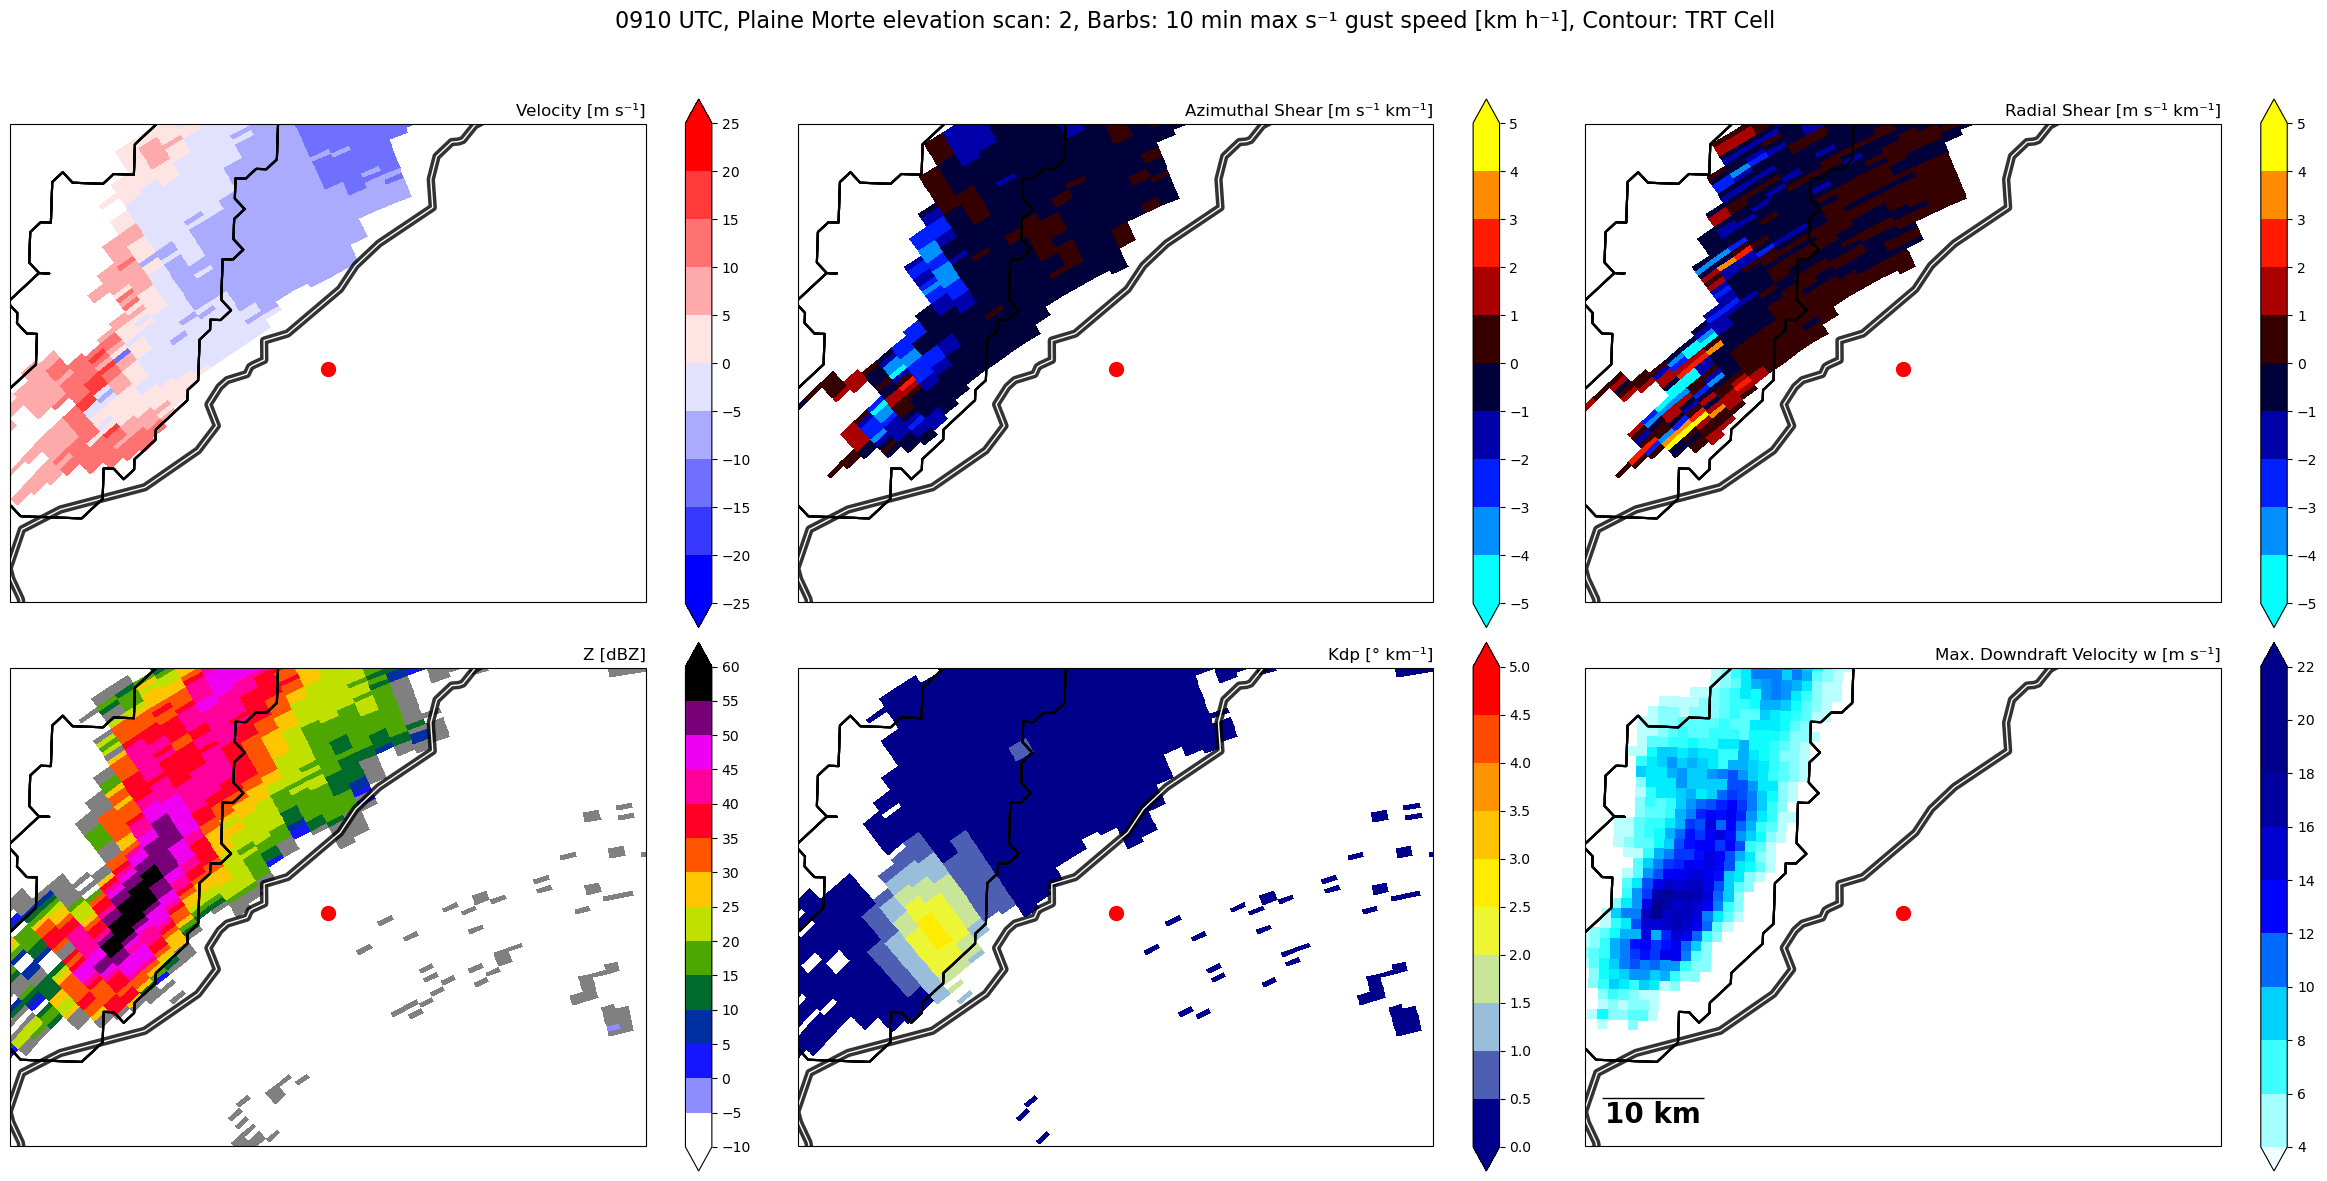

In [55]:
# La Chaux-de-Fpnds
downburst_location = 'LaChaux-de-Fonds'


projection = ccrs.epsg(3035)
# Create figure with three subplots (Reflectivity, Velocity, and Dealiased Velocity)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12), subplot_kw={'projection': projection})

# Set background to black for all subplots
for row in axs:  # axs is a 2D array, so iterate through rows
    for ax in row:  # Iterate through each subplot in the row
        fig.patch.set_facecolor('white')  # Set figure background
        ax.set_facecolor('white')  # Set axis background

edgecolor = 'black'




# Plot Dealiased Velocity
cmap_velocity.set_bad(color='white')
p2 = axs[0,0].pcolormesh(lons, lats, dv_velocity, cmap=cmap_velocity, norm=velocity_norm, transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(p2, ax=axs[0,0], cmap=cmap_velocity, extend='both', boundaries=velocity_levels, ticks=velocity_levels)
cbar2.outline.set_edgecolor(edgecolor)
cbar2.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color=edgecolor)
axs[0,0].set_title('Velocity [m s⁻¹]', color=edgecolor, loc='right')


# Plot Azmiuthal shear
#cmap_specw.set_bad(color='black')
cmap_az_shear.set_bad(color='white')
p9 = axs[0,1].pcolormesh(lons, lats, llsd_vel[0], cmap=cmap_az_shear, norm=az_shear_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[0,1], cmap=cmap_az_shear, extend='both', boundaries=az_shear_levels, ticks=az_shear_levels
                     )
cbar9.outline.set_edgecolor(edgecolor)
cbar9.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color=edgecolor)
axs[0,1].set_title('Azimuthal Shear [m s⁻¹ km⁻¹]', color=edgecolor, loc='right')

# Plot Radial shear
#cmap_specw.set_bad(color='black')
cmap_div_shear.set_bad(color='white')
p9 = axs[0,2].pcolormesh(lons, lats, llsd_vel[1], cmap=cmap_div_shear, norm=div_shear_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[0,2], cmap=cmap_div_shear, extend='both', boundaries=div_shear_levels, ticks=div_shear_levels
                     )
cbar9.outline.set_edgecolor(edgecolor)
cbar9.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color=edgecolor)
axs[0,2].set_title('Radial Shear [m s⁻¹ km⁻¹]', color=edgecolor, loc='right')

# Plot Reflectivity composite
cmap_czc.set_bad(color='grey')
p1 = axs[1,0].pcolormesh(lons, lats, reflectivity, cmap=cmap_czc, norm=czc_norm, transform=ccrs.PlateCarree())
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=axs[1,0], extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor(edgecolor)
cbar1.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color=edgecolor)
axs[1,0].set_title('Z [dBZ]', color=edgecolor, loc='right')


# Plot Kdp
cmap_Kdp.set_bad(color='white')
p7 = axs[1,1].pcolormesh(lons, lats, Kdp, norm=Kdp_norm,
                   cmap=cmap_Kdp, transform=ccrs.PlateCarree())
# Add a colorbar
cbar7 = plt.colorbar(p7, ax=axs[1,1], extend='both', cmap=cmap_Kdp, boundaries=Kdp_levels, ticks=Kdp_levels
                     )
cbar7.outline.set_edgecolor(edgecolor)
cbar7.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar7.ax.axes, 'yticklabels'), color=edgecolor)
axs[1,1].set_title('Kdp [° km⁻¹]', color=edgecolor, loc='right')


# Plot wge composite
# Set a mask
wge = np.ma.masked_less_equal(wge, 0)
cmap_wge.set_bad(color='white')
p12 = axs[1,2].pcolormesh(clons, clats, wge, vmax=18, 
                   cmap=cmap_wge, transform=projection)
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=axs[1,2], extend='both', cmap=cmap_wge, norm=wge_norm, boundaries=wge_levels, ticks=wge_levels
                     )
cbar12.outline.set_edgecolor(edgecolor)
cbar12.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color=edgecolor)
axs[1,2].set_title('Max. Downdraft Velocity w [m s⁻¹]', color=edgecolor, loc='right')




# Load the JSON file
with open(file_cs, 'r') as file:
    data = json.load(file)

# Convert timestamp to datetime
def convert_timestamp(ms):
    return datetime.utcfromtimestamp(ms / 1000)



valid_time3_with_colon = f"{valid_time3[:2]}:{valid_time3[2:]}"  # Add colon to valid_time3

# Convert valid_time3 to a datetime object
valid_time3_datetime = datetime.strptime(f'2023-07-24 {valid_time3_with_colon}', '%Y-%m-%d %H:%M')

# Calculate valid_time as 2 hours before valid_time3
valid_time = valid_time3_datetime - timedelta(hours=2)

# Format valid_time as a string with the desired format
valid_time_str = valid_time.strftime('%Y-%m-%d %H:%M:%S')

print(f"valid_time3: {valid_time3_with_colon}")
print(f"valid_time: {valid_time_str}")




# Set the valid time and time range
time_range = timedelta(minutes=2.5)

# Filter features within the time range
filtered_features = [
    feature for feature in data
    if abs(convert_timestamp(feature['properties']['timestamp']) - valid_time) <= time_range
]

# Plot the features
for feature in filtered_features:
    lon, lat = feature['geometry']['coordinates']
    for row in axs:
        for ax in row:
            ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=10)





# Define the size of the size bar (in map units, e.g., meters)
size_bar_length = 10000  # 10 km in meters (adjust as needed)
size_bar_text = '10 km'  # Text to display next to the size bar

# Create the size bar font
size_bar_font = fm.FontProperties(size=20, weight='bold')

# Add size bar to the second plot
size_bar_ax2 = AnchoredSizeBar(
    axs[1,2].transData,  # Transformation for positioning
    size_bar_length,    # Length of the size bar
    size_bar_text,      # Label for the size bar
    loc='lower left',   # Location on the plot
    pad=0.5,            # Padding around the bar
    color='black',      # Color of the size bar
    frameon=False,      # No frame around the bar
    size_vertical=50,   # Thickness of the bar
    fontproperties=size_bar_font  # Font properties for the label
)
#ax.add_artist(size_bar_ax2)  # Add the size bar to the second axis
axs[1,2].add_artist(size_bar_ax2)  # Add the size bar to the second axis



# (Plotting of wind barbs and other features remains the same)
# Add Radar, Geneva, and Lausanne locations to all plots
for row in axs:
    for ax in row:
    
        # Set the spatial extent of the plot
        ax.set_extent([LaChauxDeFonds_lon-0.4, LaChauxDeFonds_lon+0.4, LaChauxDeFonds_lat-0.2, LaChauxDeFonds_lat+0.2], 
                  crs=ccrs.PlateCarree())
    
        # Add geographic features
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=6)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=6)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=6)
        ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=1)
        ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=1)
        ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=1)
        ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), colors='black', alpha=0.5, transform=ccrs.PlateCarree())
        

# Set main title
plt.suptitle(valid_time3 + ' UTC, ' + radar_name + ' elevation scan: ' + elevation_scan + ', Barbs: 10 min max s⁻¹ gust speed [km h⁻¹], Contour: TRT Cell', color=edgecolor, fontsize=16, x=0.5)
# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("/users/fackerma/newproject1/figures/sixth_case/TRTC1/TRT_" + downburst_location + "_" + radar_station + "_" + valid_time3 + "_" + elevation_scan + ".png", dpi=300)

## RHI

[47.08293940202013, 6.792312975308194, 1066.83196756]
Azimuth angle to downburst occurrence: 326.48 degrees
Looking for files with time: 0910
Files found for time 0910: ['/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.001', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.002', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.003', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.004', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.005', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.006', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.007', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.008', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.009', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.010', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.011', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509100U.012', '/scratch/mch/fackerma/orders/case_240

/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pyart/aux_io/metranet_reader.py:142: UserWarning: Invalid reader name or C library not available, using python (default) instead
  warn('Invalid reader name or C library not available,' +


Looking for files with time: 0915
Files found for time 0915: ['/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.001', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.002', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.003', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.004', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.005', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.006', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.007', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.008', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.009', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.010', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.011', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.012', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.013', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509150U.014', '/scratch/mch/

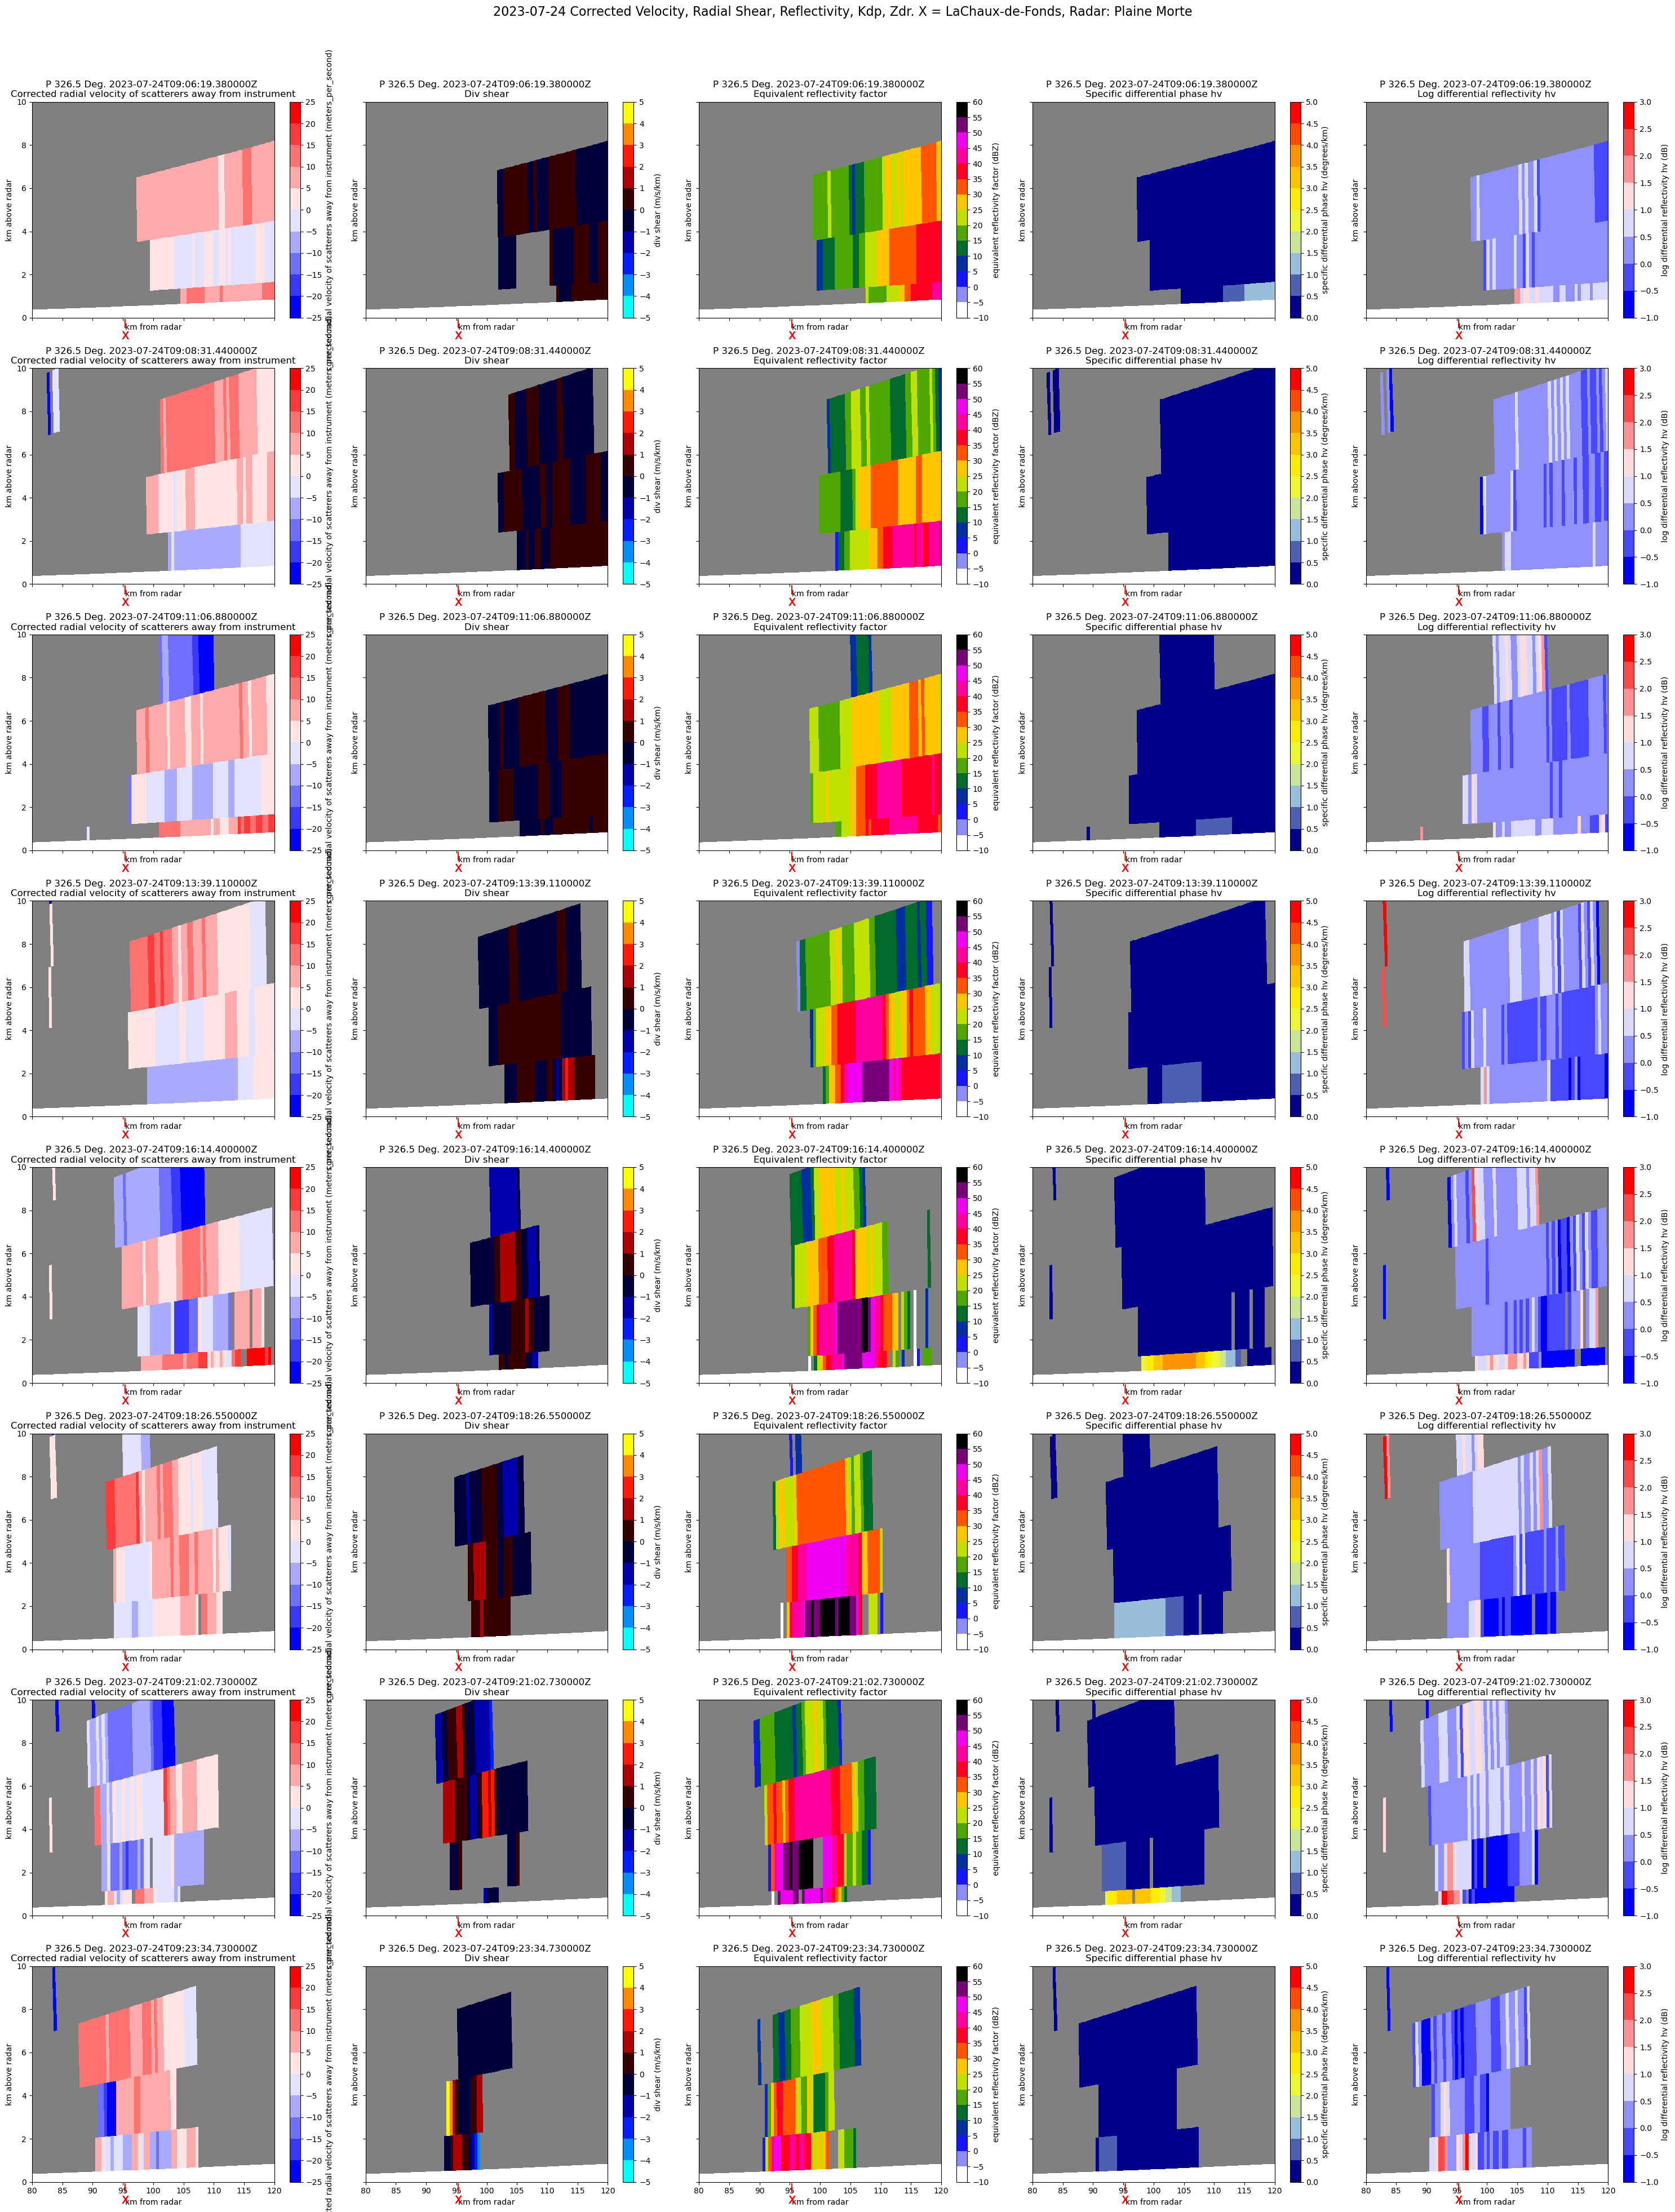

In [8]:
# hightemp St. Gallen 1900
downburst_location = 'LaChaux-de-Fonds'
downburst_x = 550919
downburst_y = 214861
downburst_z = 1017

if radar_station == 'P':
    rhi_distance = 120
    rhi_close = 80


# Define time intervals: x minutes before, and the exact time
time_deltas = [-15, -10, -5, 0]  # minutes
first_scan = ['001', '003', '005', '007', '009', '011', '013', '015', '017', '019']
second_scan = ['002', '004', '006', '008', '010', '012', '014', '016', '018', '020']

wgs84 = converter.LV03toWGS84(downburst_x, downburst_y, downburst_z)
print(wgs84)
downburst_lat = wgs84[0]
downburst_lon = wgs84[1]


# La Chaux-de-Fonds aérodrome
#downburst_location = 'LaChaux-de-Fonds_CS1'
#downburst_lat = 47.100209539033 
#downburst_lon = 6.824997818375689


radar_coords = (radar_lat, radar_lon)
downburst_coords = (downburst_lat, downburst_lon)
downburst_distance = geopy.distance.geodesic(radar_coords, downburst_coords).km

# Calculate azimuth
azimuth_to_downburst = calculate_azimuth(radar_lat, radar_lon, downburst_lat, downburst_lon)
print(f"Azimuth angle to downburst occurrence: {azimuth_to_downburst:.2f} degrees")

# Convert valid_time3 to a datetime object
base_time = datetime.strptime(valid_time3, "%H%M")


# Set up the figure with 4 rows and 4 columns
fig, axes = plt.subplots(8, 5, sharex=True, sharey=True, figsize=(30, 40))
fig.suptitle("2023-07-24 Corrected Velocity, Radial Shear, Reflectivity, Kdp, Zdr. X = " + downburst_location + ", Radar: " + radar_name, fontsize=16)

for row, delta in enumerate(time_deltas):
    # Calculate the time for this row
    current_time = (base_time + timedelta(minutes=delta)).strftime("%H%M")
    print(f"Looking for files with time: {current_time}")
    
    # Check what files are available in the directory
    files_rhi = sorted(glob.glob(f"{path}/ML/ML{radar_station}23205{current_time}*"))
    print(f"Files found for time {current_time}: {files_rhi}")

    # Separate the files into two lists
    file_rhi_first_scan = []
    file_rhi_second_scan = []

    for file in files_rhi:
        # Extract the elevation scan number (last two digits before the file extension)
        elevation_scan = file.split('.')[-1]
    
        if elevation_scan in first_scan:
            file_rhi_first_scan.append(file)
        elif elevation_scan in second_scan:
            file_rhi_second_scan.append(file)

    # Merge radar data for the current time
    for i, f in enumerate(files_rhi):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged = radar
        else:
            radar_merged = pyart.util.join_radar(radar_merged, radar)
    
    # Merge radar data for first scan
    radar_merged_first_scan = None
    for i, f in enumerate(file_rhi_first_scan):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged_first_scan = radar
        else:
            radar_merged_first_scan = pyart.util.join_radar(radar_merged_first_scan, radar)

    # Merge radar data for second scan  
    radar_merged_second_scan = None
    for i, f in enumerate(file_rhi_second_scan):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged_second_scan = radar
        else:
            radar_merged_second_scan = pyart.util.join_radar(radar_merged_second_scan, radar)

    # Perform dealiasing
    #corr_vel = pyart.correct.dealias_region_based(radar_merged)
    corr_vel_first_scan = pyart.correct.dealias_region_based(radar_merged_first_scan)
    corr_vel_second_scan = pyart.correct.dealias_region_based(radar_merged_second_scan)

    # Add 'corrected_velocity' field if it doesn't already exist
    #if 'corrected_velocity' not in radar_merged.fields:
        #radar_merged.add_field('corrected_velocity', corr_vel)
    #else:
        #print(f"Field 'corrected_velocity' already exists for time {current_time}. Skipping addition.")

    # Add 'corrected_velocity' field if it doesn't already exist
    if 'corrected_velocity' not in radar_merged_first_scan.fields:
        radar_merged_first_scan.add_field('corrected_velocity', corr_vel_first_scan)
    else:
        print(f"Field 'corrected_velocity_first_scan' already exists for time {current_time}. Skipping addition.")

    # Add 'corrected_velocity' field if it doesn't already exist
    if 'corrected_velocity' not in radar_merged_second_scan.fields:
        radar_merged_second_scan.add_field('corrected_velocity', corr_vel_second_scan)
    else:
        print(f"Field 'corrected_velocity_second_scan' already exists for time {current_time}. Skipping addition.")

    #div_shear = llsd(vel=radar_merged.fields['corrected_velocity']['data'], az_min=3, az_max=90, w_k=1.5, r_k=2, resolution=0.5)
    div_shear_first_scan = llsd(vel=radar_merged_first_scan.fields['corrected_velocity']['data'], az_min=3, az_max=90, w_k=5, r_k=5, resolution=0.5)
    div_shear_second_scan = llsd(vel=radar_merged_second_scan.fields['corrected_velocity']['data'], az_min=3, az_max=90, w_k=5, r_k=5, resolution=0.5)

    # Assuming div_shear is a NumPy array or similar
    div_shear_dict_first_scan = {
        'data': div_shear_first_scan[1],  # This should be the numerical array
        'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
        'long_name': 'Divergence Shear',  # Add a descriptive name for the field
        'standard_name': 'div_shear',  # You can add any standard name
    }
    radar_merged_first_scan.add_field('div_shear', div_shear_dict_first_scan)
    # Assuming div_shear is a NumPy array or similar
    div_shear_dict_second_scan = {
        'data': div_shear_second_scan[1],  # This should be the numerical array
        'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
        'long_name': 'Divergence Shear',  # Add a descriptive name for the field
        'standard_name': 'div_shear',  # You can add any standard name
    }
    radar_merged_second_scan.add_field('div_shear', div_shear_dict_second_scan)
    # Now, add the field to the radar object

    kdp = pyart.retrieve.kdp_vulpiani(radar_merged_first_scan, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
    radar_merged_first_scan.add_field('kdp', kdp[0])

    kdp = pyart.retrieve.kdp_vulpiani(radar_merged_second_scan, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
    radar_merged_second_scan.add_field('kdp', kdp[0])
 
    
    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi = pyart.util.cross_section_ppi(radar_merged, [azimuth_to_downburst])
    display = pyart.graph.RadarDisplay(pseudorhi)
    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi_first_scan = pyart.util.cross_section_ppi(radar_merged_first_scan, [azimuth_to_downburst])
    display_first_scan = pyart.graph.RadarDisplay(pseudorhi_first_scan)
    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi_second_scan = pyart.util.cross_section_ppi(radar_merged_second_scan, [azimuth_to_downburst])
    display_second_scan = pyart.graph.RadarDisplay(pseudorhi_second_scan)


    
        
    if delta == -15:
        ax_vel_first_scan = axes[0, 0]
        ax_ref_first_scan = axes[0, 2]
        ax_div_shear_first_scan = axes[0, 1]
        ax_kdp_first_scan = axes[0,3]
        ax_zdr_first_scan = axes[0,4]
        ax_vel_second_scan = axes[1, 0]
        ax_ref_second_scan = axes[1, 2]
        ax_div_shear_second_scan = axes[1, 1]
        ax_kdp_second_scan = axes[1,3]
        ax_zdr_second_scan = axes[1,4]

        # Plot 'corrected_velocity' with specified color limits
        cmap_velocity.set_bad(color='grey')
        display_first_scan.plot_rhi('corrected_velocity', ax=ax_vel_first_scan, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
        #ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")

        cmap_velocity.set_bad(color='grey')
        display_second_scan.plot_rhi('corrected_velocity', ax=ax_vel_second_scan, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
        #ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")
 
        cmap_div_shear.set_bad(color='grey')
        display_first_scan.plot_rhi('div_shear', ax=ax_div_shear_first_scan, ticks=div_shear_levels, norm=div_shear_norm, 
        #vmin=-20, vmax=70,
            cmap=cmap_div_shear)
        #ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")

        cmap_div_shear.set_bad(color='grey')
        display_second_scan.plot_rhi('div_shear', ax=ax_div_shear_second_scan, ticks=div_shear_levels, norm=div_shear_norm, 
        #vmin=-20, vmax=70,
            cmap=cmap_div_shear)
        #ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")

        # Plot 'reflectivity'
        cmap_czc.set_bad(color='grey')
        display_first_scan.plot_rhi('reflectivity', ax=ax_ref_first_scan, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
        #ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")  

        # Plot 'reflectivity'
        cmap_czc.set_bad(color='grey')
        display_second_scan.plot_rhi('reflectivity', ax=ax_ref_second_scan, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
        #ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")

        # Plot KDP
        cmap_Kdp.set_bad(color='grey')
        display_first_scan.plot_rhi('kdp', ax=ax_kdp_first_scan, ticks=Kdp_levels, norm=Kdp_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_Kdp)
        
        # Plot KDP
        cmap_Kdp.set_bad(color='grey')
        display_second_scan.plot_rhi('kdp', ax=ax_kdp_second_scan, ticks=Kdp_levels, norm=Kdp_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_Kdp)
        
        # Plot KDP
        cmap_diff_reflectivity.set_bad(color='grey')
        display_first_scan.plot_rhi('differential_reflectivity', ax=ax_zdr_first_scan, ticks=diff_reflectivity_levels, norm=diff_reflectivity_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_diff_reflectivity)
        
        cmap_diff_reflectivity.set_bad(color='grey')
        display_second_scan.plot_rhi('differential_reflectivity', ax=ax_zdr_second_scan, ticks=diff_reflectivity_levels, norm=diff_reflectivity_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_diff_reflectivity)
        
    if delta == -10:
        ax_vel_first_scan = axes[2, 0]
        ax_ref_first_scan = axes[2, 2]
        ax_div_shear_first_scan = axes[2, 1]
        ax_kdp_first_scan = axes[2,3]
        ax_zdr_first_scan = axes[2,4]
        ax_vel_second_scan = axes[3, 0]
        ax_ref_second_scan = axes[3, 2]
        ax_div_shear_second_scan = axes[3, 1]
        ax_kdp_second_scan = axes[3,3]
        ax_zdr_second_scan = axes[3,4]

        # Plot 'corrected_velocity' with specified color limits
        cmap_velocity.set_bad(color='grey')
        display_first_scan.plot_rhi('corrected_velocity', ax=ax_vel_first_scan, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
        #ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")

        cmap_velocity.set_bad(color='grey')
        display_second_scan.plot_rhi('corrected_velocity', ax=ax_vel_second_scan, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
        #ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")
 
        cmap_div_shear.set_bad(color='grey')
        display_first_scan.plot_rhi('div_shear', ax=ax_div_shear_first_scan, ticks=div_shear_levels, norm=div_shear_norm, 
        #vmin=-20, vmax=70,
            cmap=cmap_div_shear)
        #ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")

        cmap_div_shear.set_bad(color='grey')
        display_second_scan.plot_rhi('div_shear', ax=ax_div_shear_second_scan, ticks=div_shear_levels, norm=div_shear_norm, 
        #vmin=-20, vmax=70,
            cmap=cmap_div_shear)
        #ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")

        # Plot 'reflectivity'
        cmap_czc.set_bad(color='grey')
        display_first_scan.plot_rhi('reflectivity', ax=ax_ref_first_scan, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
        #ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")  

        # Plot 'reflectivity'
        cmap_czc.set_bad(color='grey')
        display_second_scan.plot_rhi('reflectivity', ax=ax_ref_second_scan, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
        #ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")

        # Plot KDP
        cmap_Kdp.set_bad(color='grey')
        display_first_scan.plot_rhi('kdp', ax=ax_kdp_first_scan, ticks=Kdp_levels, norm=Kdp_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_Kdp)
        
        # Plot KDP
        cmap_Kdp.set_bad(color='grey')
        display_second_scan.plot_rhi('kdp', ax=ax_kdp_second_scan, ticks=Kdp_levels, norm=Kdp_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_Kdp)
        
        # Plot Zdr
        cmap_diff_reflectivity.set_bad(color='grey')
        display_first_scan.plot_rhi('differential_reflectivity', ax=ax_zdr_first_scan, ticks=diff_reflectivity_levels, norm=diff_reflectivity_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_diff_reflectivity)
        
        cmap_diff_reflectivity.set_bad(color='grey')
        display_second_scan.plot_rhi('differential_reflectivity', ax=ax_zdr_second_scan, ticks=diff_reflectivity_levels, norm=diff_reflectivity_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_diff_reflectivity)
        
    if delta == -5:
        ax_vel_first_scan = axes[4, 0]
        ax_ref_first_scan = axes[4, 2]
        ax_div_shear_first_scan = axes[4, 1]
        ax_kdp_first_scan = axes[4,3]
        ax_zdr_first_scan = axes[4,4]
        ax_vel_second_scan = axes[5, 0]
        ax_ref_second_scan = axes[5, 2]
        ax_div_shear_second_scan = axes[5, 1]
        ax_kdp_second_scan = axes[5,3]
        ax_zdr_second_scan = axes[5,4]

        # Plot 'corrected_velocity' with specified color limits
        cmap_velocity.set_bad(color='grey')
        display_first_scan.plot_rhi('corrected_velocity', ax=ax_vel_first_scan, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
        #ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")

        cmap_velocity.set_bad(color='grey')
        display_second_scan.plot_rhi('corrected_velocity', ax=ax_vel_second_scan, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
        #ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")
 
        cmap_div_shear.set_bad(color='grey')
        display_first_scan.plot_rhi('div_shear', ax=ax_div_shear_first_scan, ticks=div_shear_levels, norm=div_shear_norm, 
        #vmin=-20, vmax=70,
            cmap=cmap_div_shear)
        #ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")

        cmap_div_shear.set_bad(color='grey')
        display_second_scan.plot_rhi('div_shear', ax=ax_div_shear_second_scan, ticks=div_shear_levels, norm=div_shear_norm, 
        #vmin=-20, vmax=70,
            cmap=cmap_div_shear)
        #ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")

        # Plot 'reflectivity'
        cmap_czc.set_bad(color='grey')
        display_first_scan.plot_rhi('reflectivity', ax=ax_ref_first_scan, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
        #ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")  

        # Plot 'reflectivity'
        cmap_czc.set_bad(color='grey')
        display_second_scan.plot_rhi('reflectivity', ax=ax_ref_second_scan, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
        #ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC") 

        # Plot KDP
        cmap_Kdp.set_bad(color='grey')
        display_first_scan.plot_rhi('kdp', ax=ax_kdp_first_scan, ticks=Kdp_levels, norm=Kdp_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_Kdp)
        
        # Plot KDP
        cmap_Kdp.set_bad(color='grey')
        display_second_scan.plot_rhi('kdp', ax=ax_kdp_second_scan, ticks=Kdp_levels, norm=Kdp_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_Kdp)
        
        # Plot Zdr
        cmap_diff_reflectivity.set_bad(color='grey')
        display_first_scan.plot_rhi('differential_reflectivity', ax=ax_zdr_first_scan, ticks=diff_reflectivity_levels, norm=diff_reflectivity_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_diff_reflectivity)
        
        cmap_diff_reflectivity.set_bad(color='grey')
        display_second_scan.plot_rhi('differential_reflectivity', ax=ax_zdr_second_scan, ticks=diff_reflectivity_levels, norm=diff_reflectivity_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_diff_reflectivity)
        
    if delta == 0:
        ax_vel_first_scan = axes[6, 0]
        ax_ref_first_scan = axes[6, 2]
        ax_div_shear_first_scan = axes[6, 1]
        ax_kdp_first_scan = axes[6,3]
        ax_zdr_first_scan = axes[6,4]
        ax_vel_second_scan = axes[7, 0]
        ax_ref_second_scan = axes[7, 2]
        ax_div_shear_second_scan = axes[7, 1]
        ax_kdp_second_scan = axes[7,3]
        ax_zdr_second_scan = axes[7,4]

        # Plot 'corrected_velocity' with specified color limits
        cmap_velocity.set_bad(color='grey')
        display_first_scan.plot_rhi('corrected_velocity', ax=ax_vel_first_scan, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
        #ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")

        cmap_velocity.set_bad(color='grey')
        display_second_scan.plot_rhi('corrected_velocity', ax=ax_vel_second_scan, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
        #ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")
 
        cmap_div_shear.set_bad(color='grey')
        display_first_scan.plot_rhi('div_shear', ax=ax_div_shear_first_scan, ticks=div_shear_levels, norm=div_shear_norm, 
        #vmin=-20, vmax=70,
            cmap=cmap_div_shear)
        #ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")

        cmap_div_shear.set_bad(color='grey')
        display_second_scan.plot_rhi('div_shear', ax=ax_div_shear_second_scan, ticks=div_shear_levels, norm=div_shear_norm, 
        #vmin=-20, vmax=70,
            cmap=cmap_div_shear)
        #ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")

        # Plot 'reflectivity'
        cmap_czc.set_bad(color='grey')
        display_first_scan.plot_rhi('reflectivity', ax=ax_ref_first_scan, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
        #ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")  

        # Plot 'reflectivity'
        cmap_czc.set_bad(color='grey')
        display_second_scan.plot_rhi('reflectivity', ax=ax_ref_second_scan, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
        #ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")

        # Plot KDP
        cmap_Kdp.set_bad(color='grey')
        display_first_scan.plot_rhi('kdp', ax=ax_kdp_first_scan, ticks=Kdp_levels, norm=Kdp_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_Kdp)
        
        # Plot KDP
        cmap_Kdp.set_bad(color='grey')
        display_second_scan.plot_rhi('kdp', ax=ax_kdp_second_scan, ticks=Kdp_levels, norm=Kdp_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_Kdp)
        
        # Plot Zdr
        cmap_diff_reflectivity.set_bad(color='grey')
        display_first_scan.plot_rhi('differential_reflectivity', ax=ax_zdr_first_scan, ticks=diff_reflectivity_levels, norm=diff_reflectivity_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_diff_reflectivity)
        
        cmap_diff_reflectivity.set_bad(color='grey')
        display_second_scan.plot_rhi('differential_reflectivity', ax=ax_zdr_second_scan, ticks=diff_reflectivity_levels, norm=diff_reflectivity_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_diff_reflectivity)
    
# Loop over rows
for row in range(8):  # Adjust depending on the number of rows in your layout
    for col in range(5):  # Adjust depending on the number of columns
        ax_vel = axes[row, 0]  # Velocity plot
        ax_ref = axes[row, 2]  # Reflectivity plot
        ax_div_shear = axes[row, 1]  # Divergence/Shear plot
        ax_kdp = axes[row, 3]
        ax_zdr = axes[row, 4]

        # Annotate 'X' on the axes where needed
        for axis in [ax_vel, ax_ref, ax_div_shear, ax_kdp, ax_zdr]:
            axis.annotate('X', xy=(downburst_distance, 0), xytext=(downburst_distance, -1),
                          textcoords='data', ha='center', color='red', fontsize=14,
                          arrowprops=dict(arrowstyle='-', color='red'))

        # Set axis limits for each axis
        ax_vel.set_ylim([0, 10])   # Adjust height range as needed
        ax_vel.set_xlim([rhi_close, rhi_distance])  # Adjust distance range as needed

        # Set labels for all axes
        ax_vel.set_xlabel('km from radar')
        ax_vel.set_ylabel('km above radar')
        
        ax_ref.set_xlabel('km from radar')
        ax_ref.set_ylabel('km above radar')

        ax_div_shear.set_xlabel('km from radar')
        ax_div_shear.set_ylabel('km above radar')

        ax_kdp.set_xlabel('km from radar')
        ax_kdp.set_ylabel('km above radar')

        ax_zdr.set_xlabel('km from radar')
        ax_zdr.set_ylabel('km above radar')



plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
#plt.savefig("/users/fackerma/newproject1/figures/sixth_case/RHI1/" + radar_station + "RHIhightemp_" + valid_time3 + "_" + downburst_location + "_2.png", dpi=300)


## Optical Flow

/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050930VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050935VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050940VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050945VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050950VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050955VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232051000VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232051005VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232051010VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232051015VL.801
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0


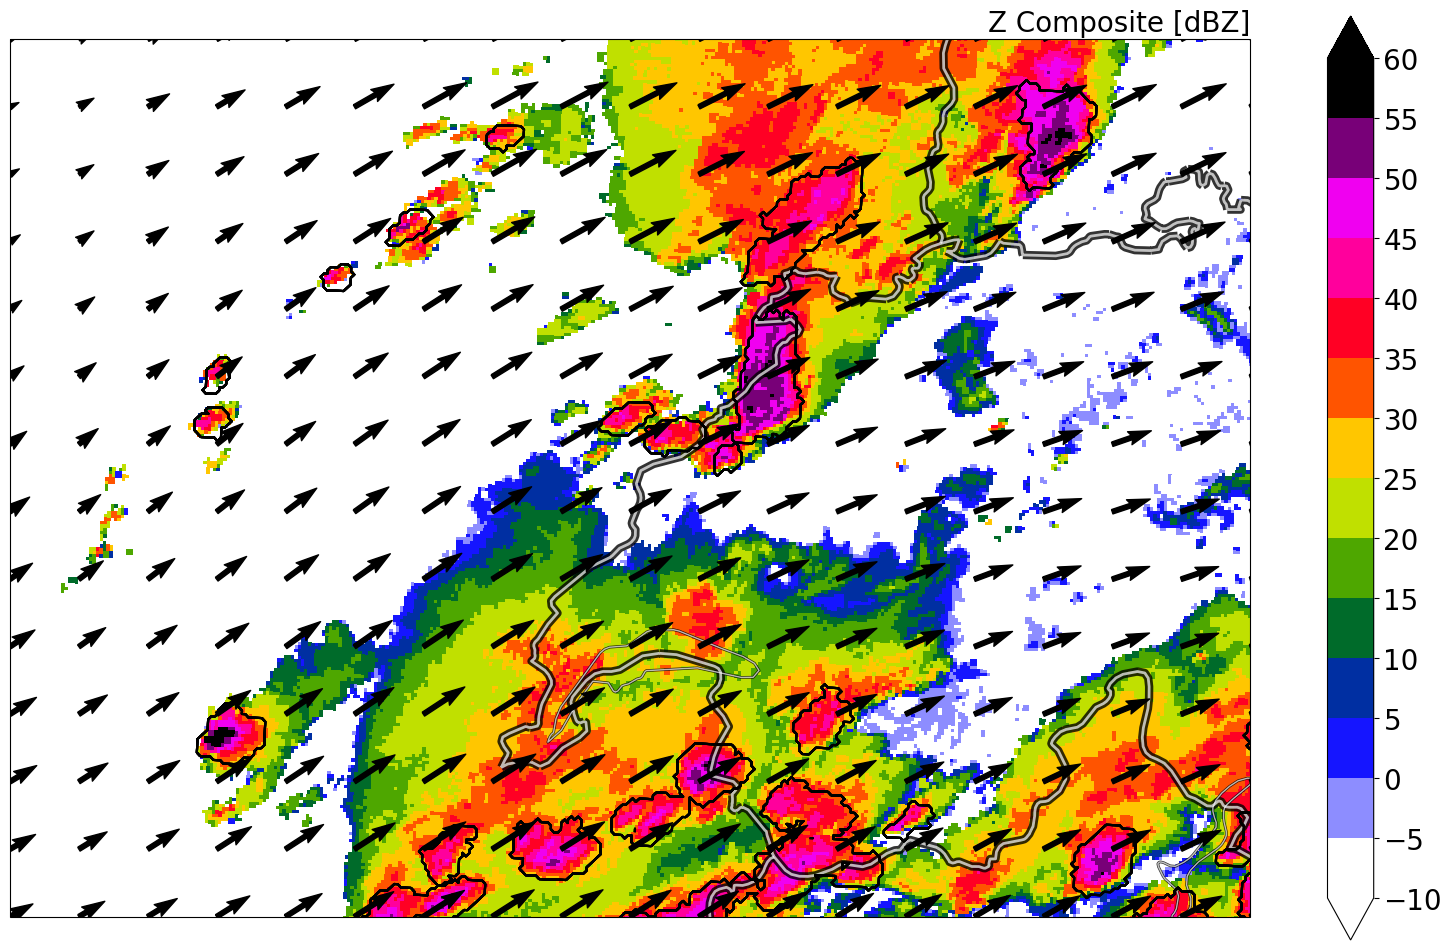

In [5]:

# Parameters for generating file paths
start_hour = int(valid_time3[:2])
start_time = int(valid_time3[2:])  # Starting time in minutes (e.g., 50 for 19:50 UTC)
time_interval = 5  # Time interval between files in minutes
num_files = 10  # Total number of files


# Generate file paths dynamically based on the starting time and interval
file_paths = []
current_hour = start_hour
current_minute = start_time

# Generate file paths dynamically based on the starting time and interval
#file_paths = [
 #   f'/scratch/mch/fackerma/orders/case_240823/CZC/CZC23236{start_hour}{str((start_time + i * time_interval) % 60).zfill(2)}VL.801'
#    for i in range(num_files)
#]

for i in range(num_files):
    # Append the file path for the current time
    file_paths.append(
        f'/scratch/mch/fackerma/orders/case_240723/CZC/CZC23205{str(current_hour).zfill(2)}{str(current_minute).zfill(2)}VL.801'
    )
    # Update minutes and handle rollover to the next hour
    current_minute += time_interval
    if current_minute >= 60:
        current_minute -= 60
        current_hour += 1
        if current_hour >= 24:  # Handle 24-hour format rollover
            current_hour = 0

# Print file paths to verify
for path in file_paths:
    print(path)

# Initialize an empty list to hold the data arrays
czc_data_list = []

# Read the radar data and extract the data arrays
for file_path in file_paths:
    czc_data = radlib.read_file(file_path, physic_value=True)
    czc_data_list.append(czc_data.data)

# Stack the data into a 3D array with shape (t, x, y)
input_images = np.stack(czc_data_list, axis=0)
input_images = np.nan_to_num(input_images, nan=0.0, posinf=0.0, neginf=0.0)


# Compute motion field using Lucas-Kanade optical flow
#oflow = motion.lucaskanade.dense_lucaskanade(input_images)
oflow = motion.darts.DARTS(input_images)
#oflow = motion.proesmans.proesmans(input_images)

# Set the projection to EPSG:3035
projection = ccrs.epsg(3035)


# Extract u (horizontal) and v (vertical) motion components
u = oflow[0]
v = oflow[1]


# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(20, 12), subplot_kw={'projection': projection})

# Set background to black for the subplot
fig.patch.set_facecolor('white')  # Set figure background color
ax.set_facecolor('white')  # Set axis background color
edgecolor = 'black'

# Plot Reflectivity composite (czc)
cmap_czc.set_bad(color='grey')
p1 = ax.pcolormesh(clons, clats, czc, norm=czc_norm,
                   cmap=cmap_czc, transform=projection)

# Add a colorbar
cbar1 = plt.colorbar(p1, ax=ax, extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor(edgecolor)
cbar1.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color=edgecolor, fontsize=20)

# Set title for the plot
ax.set_title('Z Composite [dBZ]', color=edgecolor, loc='right', fontsize=20)
ax.set_extent(WestSwitzrelandLarge_extent, crs=ccrs.PlateCarree())

# Add borders, coastlines, and lakes with custom contour lines
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=6)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7, linewidth=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)

clons_adj = clons[:-1, :-1]
clats_adj = clats[:-1, :-1]

step = 20  # Adjust to reduce density of barbs
clons_down = clons_adj[::step, ::step]
clats_down = clats_adj[::step, ::step]
u_down = u[::step, ::step]
v_down = v[::step, ::step]

u_down = u_down
v_down = -v_down

barbs = ax.quiver(
    clons_down, clats_down, u_down, v_down,
    transform=projection, color='black', alpha=1, edgecolor='black', linewidth=1, zorder=20,
    #length=7, linewidth=1, 
    regrid_shape=14  # Adjust length and regrid_shape
)

from matplotlib.colors import to_rgba
lime_green_with_alpha = to_rgba("lime", alpha=0.5)
ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11),
           colors='black',
            alpha=1,transform=ccrs.PlateCarree())



#plt.savefig("/users/fackerma/newproject1/figures/sixth_case/OF_" + valid_time3 + "_1" ".png", dpi=300)




## Custom Plots

[47.08293940202013, 6.792312975308194, 1066.83196756]
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050925VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050930VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050935VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050940VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050945VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050950VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232050955VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232051000VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232051005VL.801
/scratch/mch/fackerma/orders/case_240723/CZC/CZC232051010VL.801
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG

/tmp/ipykernel_201014/891529999.py:280: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ms / 1000)


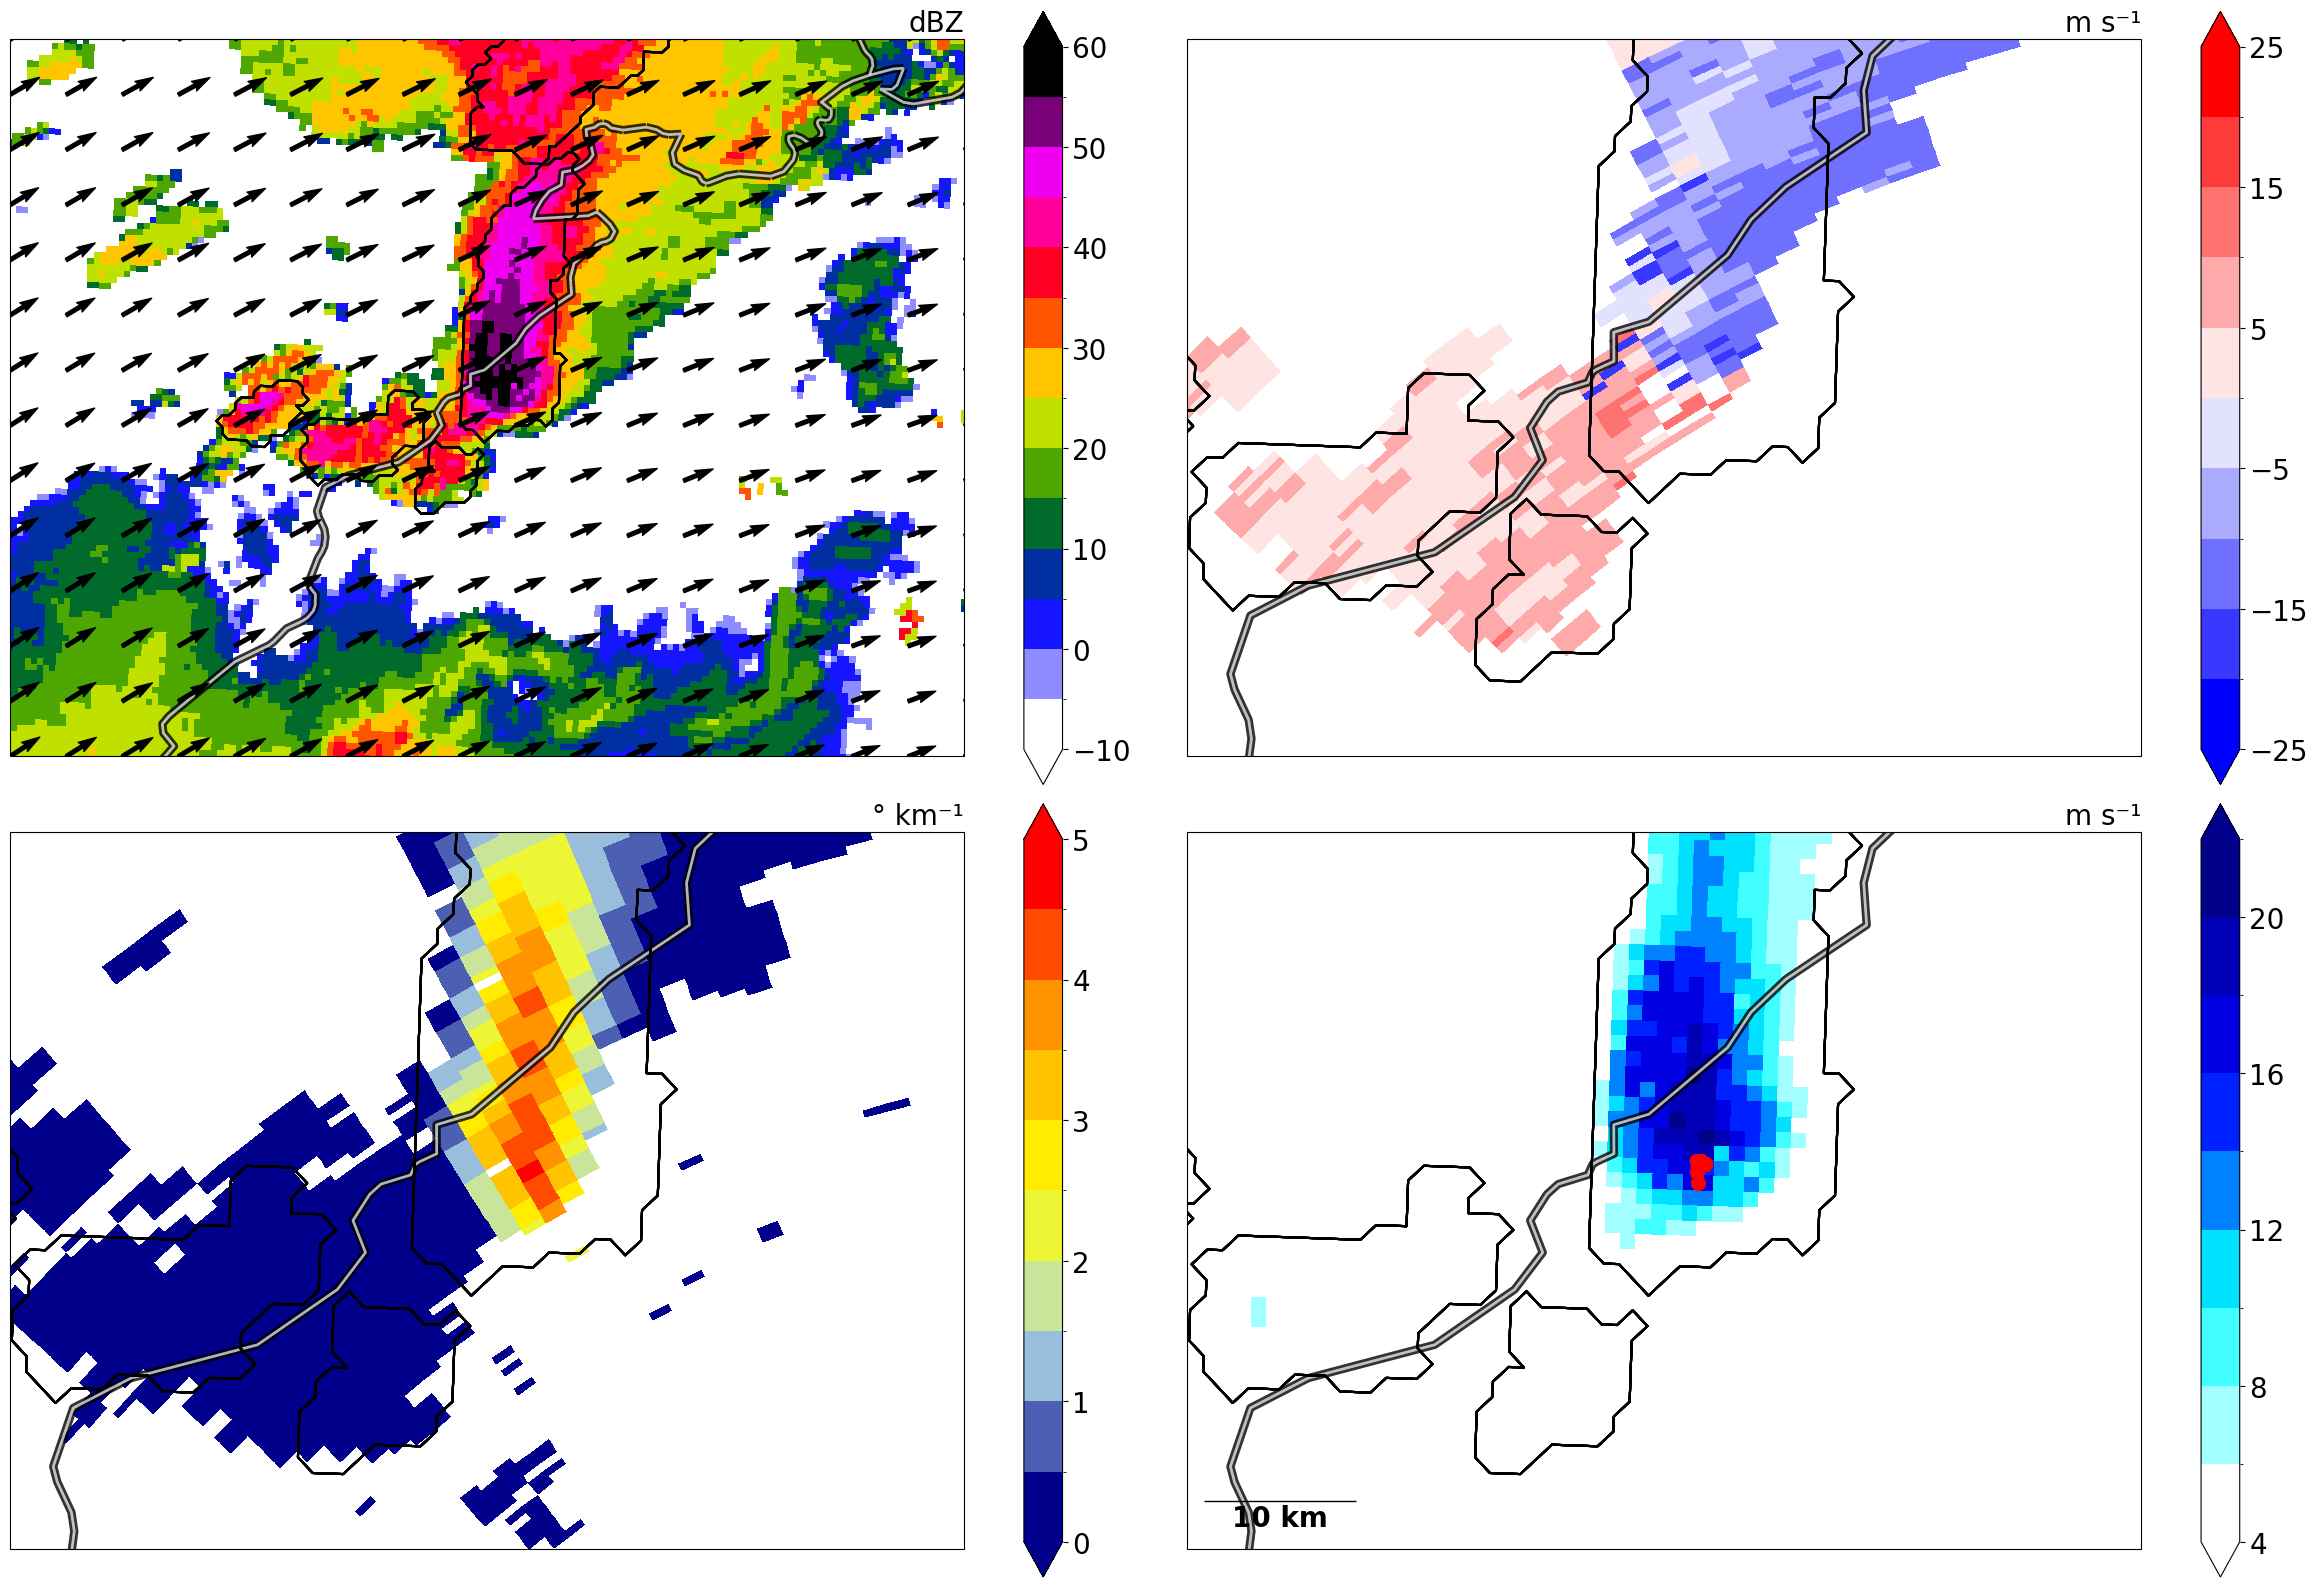

In [15]:
# 2230 OF, Kdp, 3rd and 7th elevation velocity of Monte Lema
projection = ccrs.epsg(3035)
fig, axs = plt.subplots(2, 2, figsize=(24, 16), subplot_kw={'projection': projection})
# Set the projection to EPSG:3035

# Set background to black for the subplot
fig.patch.set_facecolor('white')  # Set figure background color
#ax.set_facecolor('white')  # Set axis background color
edgecolor = 'black'

valid_time3 = '0925'

downburst_location = 'LaChaux-de-Fonds'
downburst_x = 550919
downburst_y = 214861
downburst_z = 1017
wgs84 = converter.LV03toWGS84(downburst_x, downburst_y, downburst_z)
print(wgs84)
downburst_lat = wgs84[0]
downburst_lon = wgs84[1]

# Parameters for generating file paths
start_hour = int(valid_time3[:2])  # Extract the first two characters as the hour
start_time = int(valid_time3[2:])  # Extract the last two characters as the minutes
time_interval = 5  # Time interval between files in minutes
num_files = 10  

# Generate file paths dynamically based on the starting time and interval
file_paths = []
current_hour = start_hour
current_minute = start_time

for i in range(num_files):
    # Append the file path for the current time
    file_paths.append(
        f'/scratch/mch/fackerma/orders/case_240723/CZC/CZC23205{str(current_hour).zfill(2)}{str(current_minute).zfill(2)}VL.801'
    )
    # Update minutes and handle rollover to the next hour
    current_minute += time_interval
    if current_minute >= 60:
        current_minute -= 60
        current_hour += 1
        if current_hour >= 24:  # Handle 24-hour format rollover
            current_hour = 0

# Print file paths to verify
for path in file_paths:
    print(path)

# Initialize an empty list to hold the data arrays
czc_data_list = []

# Read the radar data and extract the data arrays
for file_path in file_paths:
    czc_data = radlib.read_file(file_path, physic_value=True)
    czc_data_list.append(czc_data.data)

# Stack the data into a 3D array with shape (t, x, y)
input_images = np.stack(czc_data_list, axis=0)
input_images = np.nan_to_num(input_images, nan=0.0, posinf=0.0, neginf=0.0)


# Compute motion field using Lucas-Kanade optical flow
#oflow = motion.lucaskanade.dense_lucaskanade(input_images)
oflow = motion.darts.DARTS(input_images)
#oflow = motion.proesmans.proesmans(input_images)

# Set the projection to EPSG:3035
projection = ccrs.epsg(3035)


# Extract u (horizontal) and v (vertical) motion components
u = oflow[0]
v = oflow[1]







ax = axs[0,0]
cmap_czc.set_bad(color='grey')
p1 = ax.pcolormesh(clons, clats, czc, #vmin=-10, vmax=60,  
                   cmap=cmap_czc, transform=projection, norm=czc_norm)
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=ax, extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor(edgecolor)
cbar1.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color=edgecolor, fontsize=20)
ticks = cbar1.get_ticks()  # Get all ticks
cbar1.set_ticks(ticks[::2])
# Set title for the plot
ax.set_title('dBZ', color=edgecolor, loc='right', fontsize=20)
ax.set_extent([downburst_lon - 1, downburst_lon + 1, downburst_lat -0.5, downburst_lat + 0.5], crs=ccrs.PlateCarree())

# Add borders, coastlines, and lakes with custom contour lines
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=6)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=4)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=4)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7, linewidth=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)

clons_adj = clons[:-1, :-1]
clats_adj = clats[:-1, :-1]

step = 20  # Adjust to reduce density of barbs
clons_down = clons_adj[::step, ::step]
clats_down = clats_adj[::step, ::step]
u_down = u[::step, ::step]
v_down = v[::step, ::step]

u_down = u_down
v_down = -v_down

barbs = ax.quiver(
    clons_down, clats_down, u_down, v_down,
    transform=projection, color='black', alpha=1, edgecolor='black', linewidth=1, zorder=20,
    #length=7, linewidth=1, 
    regrid_shape=14  # Adjust length and regrid_shape
)
ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), #colors=[lime_green_with_alpha],
           colors='black',
            alpha=1,  transform=ccrs.PlateCarree())






radar_station = 'P'
elevation_scan = '1'
path = '/scratch/mch/fackerma/orders/case_240723'
file2 = glob.glob(path +'/DVA/srn/data/tmp/mof/DV' + radar_station + '/DV' + radar_station + '23205' + valid_time3 + '7L.80' + elevation_scan) # Dealiased velocity
dv_data = pyart.aux_io.read_file_py(file2[0], physic_value=False)
dv_digital = dv_data.data
dv_header = dv_data.header
nyq = float(dv_header['nyquist'])
dv_velocity = transform_from_digital(dv_digital, nyq)
file = glob.glob(path + '/ML/ML' + radar_station + '23205' + valid_time3 + '0U.00' + elevation_scan) # ML data 
# Read the data for the plots
data = pyart.aux_io.read_metranet(file[0], reader='python')
velocity = data.get_field(0, 'velocity').data
reflectivity = data.get_field(0, 'reflectivity').data
resolution = 0.5
range_max = reflectivity.shape[1] * resolution
azimuths = np.linspace(0, 360, reflectivity.shape[0])
ranges = np.arange(0, range_max, resolution)
lats, lons = radar_to_latlon(radar_lat, radar_lon, ranges, azimuths)
# KDP Vulpiani Method
Kdp = pyart.retrieve.kdp_vulpiani(data, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
Kdp = Kdp[0]['data']


# Plot Kdp
ax = axs[1,0]
cmap_Kdp.set_bad(color='white')
p7 = ax.pcolormesh(lons, lats, Kdp, norm=Kdp_norm,
                   cmap=cmap_Kdp, transform=ccrs.PlateCarree())
# Add a colorbar
cbar7 = plt.colorbar(p7, ax=ax, extend='both', cmap=cmap_Kdp, boundaries=Kdp_levels, ticks=Kdp_levels
                     )
cbar7.outline.set_edgecolor(edgecolor)
cbar7.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar7.ax.axes, 'yticklabels'), color=edgecolor, fontsize=20)
ticks = cbar7.get_ticks()  # Get all ticks
cbar7.set_ticks(ticks[::2])
ax.set_title('° km⁻¹', color=edgecolor, loc='right', fontsize = 20)
ax.set_extent([downburst_lon - 0.4, downburst_lon + 0.4, downburst_lat -0.2, downburst_lat + 0.2], 
                  crs=ccrs.PlateCarree())
# Add borders, coastlines, and lakes with custom contour lines
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=6)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7, linewidth=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), #colors=[lime_green_with_alpha],
           colors='black',
            alpha=1, transform=ccrs.PlateCarree())



ax = axs[0,1]
cmap_velocity.set_bad(color='white')
p1 = ax.pcolormesh(lons, lats, dv_velocity, #vmin=-10, vmax=60, 
                   cmap=cmap_velocity, transform=ccrs.PlateCarree(), norm=velocity_norm)
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=ax, extend='both', cmap=cmap_velocity, norm=velocity_norm, boundaries=velocity_levels, ticks=velocity_levels
                     )
cbar1.outline.set_edgecolor(edgecolor)
cbar1.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color=edgecolor, fontsize=20)
ticks = cbar1.get_ticks()  # Get all ticks
cbar1.set_ticks(ticks[::2])

# Set title for the plot
ax.set_title('m s⁻¹', color=edgecolor, loc='right', fontsize=20)
ax.set_extent([downburst_lon - 0.4, downburst_lon + 0.4, downburst_lat -0.2, downburst_lat + 0.2], 
                  crs=ccrs.PlateCarree())
# Add borders, coastlines, and lakes with custom contour lines
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=6)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7, linewidth=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), 
           colors='black',
            alpha=1, transform=ccrs.PlateCarree())







ax = axs[1,1]

wge = np.ma.masked_less_equal(wge, 0)
cmap_wge.set_bad(color='white')
p12 = ax.pcolormesh(clons, clats, wge, norm=wge_norm,
                   cmap=cmap_wge, transform=projection)
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=ax, extend='both', cmap=cmap_wge, norm=wge_norm, boundaries=wge_levels, ticks=wge_levels
                     )
cbar12.outline.set_edgecolor(edgecolor)
cbar12.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color=edgecolor, fontsize = 20)
ax.set_title('m s⁻¹', color=edgecolor, loc='right', fontsize = 20)
ticks = cbar12.get_ticks()  # Get all ticks
cbar12.set_ticks(ticks[::2])
ax.set_extent([downburst_lon - 0.4, downburst_lon + 0.4, downburst_lat -0.2, downburst_lat + 0.2], 
                  crs=ccrs.PlateCarree())
# Add borders, coastlines, and lakes with custom contour lines
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=6)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7, linewidth=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), 
           colors='black',
            alpha=1, transform=ccrs.PlateCarree())


from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Define the size of the size bar (in map units, e.g., meters)
size_bar_length = 10000  # 10 km in meters (adjust as needed)
size_bar_text = '10 km'  # Text to display next to the size bar

# Create the size bar font
size_bar_font = fm.FontProperties(size=20, weight='bold')

# Add size bar to the second plot
size_bar_ax2 = AnchoredSizeBar(
    axs[1,1].transData,  # Transformation for positioning
    size_bar_length,    # Length of the size bar
    size_bar_text,      # Label for the size bar
    loc='lower left',   # Location on the plot
    pad=0.5,            # Padding around the bar
    color='black',      # Color of the size bar
    frameon=False,      # No frame around the bar
    size_vertical=50,   # Thickness of the bar
    fontproperties=size_bar_font  # Font properties for the label
)
axs[1,1].add_artist(size_bar_ax2)  # Add the size bar to the second axis


# Load the JSON file
with open(file_cs, 'r') as file:
    data = json.load(file)

# Convert timestamp to datetime
def convert_timestamp(ms):
    return datetime.utcfromtimestamp(ms / 1000)



valid_time3_with_colon = f"{valid_time3[:2]}:{valid_time3[2:]}"  # Add colon to valid_time3

# Convert valid_time3 to a datetime object
valid_time3_datetime = datetime.strptime(f'2023-07-24 {valid_time3_with_colon}', '%Y-%m-%d %H:%M')

# Calculate valid_time as 2 hours before valid_time3
valid_time = valid_time3_datetime - timedelta(hours=2)

# Format valid_time as a string with the desired format
valid_time_str = valid_time.strftime('%Y-%m-%d %H:%M:%S')

print(f"valid_time3: {valid_time3_with_colon}")
print(f"valid_time: {valid_time_str}")




# Set the valid time and time range
time_range = timedelta(minutes=2.5)

# Filter features within the time range
filtered_features = [
    feature for feature in data
    if abs(convert_timestamp(feature['properties']['timestamp']) - valid_time) <= time_range
]

# Plot the features
for feature in filtered_features:
    lon, lat = feature['geometry']['coordinates']
    ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=10)






plt.tight_layout()

#plt.savefig("/users/fackerma/newproject1/figures/sixth_case/" + valid_time3 + "_OF_Kdp_Vel_w" ".png", dpi=300)

In [6]:
# Locarno RHIs for Weissfluhgipfel and Lema for 0656 UTC

downburst_location = 'LaChaux-de-Fonds'


downburst_lat_locarno = 47.100209539033 
downburst_lon_locarno = 6.824997818375689


rhi_close_lema = 80
rhi_distance_lema = 110
rhi_close_weissfluhgipfel = 80
rhi_distance_weissfluhgipfel = 110


radar_lat_lema = 46.37083
radar_lon_lema = 7.48694
radar_alt_lema = 2927 


radar_lat_weissfluhgipfel = 46.37083
radar_lon_weissfluhgipfel = 7.48694
radar_alt_weissfluhgipfel = 2927 

radar_coords_lema = (radar_lat_lema, radar_lon_lema)
radar_coords_weissfluhgipfel = (radar_lat_weissfluhgipfel, radar_lon_weissfluhgipfel)
downburst_coords_locarno = (downburst_lat_locarno, downburst_lon_locarno)

downburst_distance_weissfluhgipfel = geopy.distance.geodesic(radar_coords_weissfluhgipfel, downburst_coords_locarno).km

# Calculate azimuth
azimuth_to_downburst_weissfluhgipfel = calculate_azimuth(radar_lat_weissfluhgipfel, radar_lon_weissfluhgipfel, downburst_lat_locarno, downburst_lon_locarno)

print(f"Azimuth angle to downburst occurrence Weissfluhgipfel: {azimuth_to_downburst_weissfluhgipfel:.2f} degrees")




valid_time3 = '0925'
elevation_scan = '1'
radar_station = 'P'
radar_name = 'Plaine Morte'

# Load radar data
path = '/scratch/mch/fackerma/orders/case_240723'
file = glob.glob(path + '/ML/ML' + radar_station + '23205' + valid_time3 + '0U.00' + elevation_scan) # ML data 
# Read the data for the plots
data = pyart.aux_io.read_metranet(file[0], reader='python')
velocity = data.get_field(0, 'velocity').data
reflectivity = data.get_field(0, 'reflectivity').data

# Define time intervals: x minutes before, and the exact time
time_deltas = [ 0]  # minute
first_scan = ['001', '003', '005', '007', '009', '011', '013', '015', '017', '019']
second_scan = ['002', '004', '006', '008', '010', '012', '014', '016', '018', '020']

# Convert valid_time3 to a datetime object
base_time = datetime.strptime(valid_time3, "%H%M")

for row, delta in enumerate(time_deltas):
    # Calculate the time for this row
    current_time = (base_time + timedelta(minutes=delta)).strftime("%H%M")
    print(f"Looking for files with time: {current_time}")
    
    # Check what files are available in the directory
    files_rhi = sorted(glob.glob(f"{path}/ML/ML{radar_station}23205{current_time}*"))
    print(f"Files found for time {current_time}: {files_rhi}")

    # Separate the files into two lists
    file_rhi_first_scan = []
    file_rhi_second_scan = []

    for file in files_rhi:
        # Extract the elevation scan number (last two digits before the file extension)
        elevation_scan = file.split('.')[-1]
    
        if elevation_scan in first_scan:
            file_rhi_first_scan.append(file)
        elif elevation_scan in second_scan:
            file_rhi_second_scan.append(file)
    
    # Merge radar data for first scan
    radar_merged_first_scan = None
    for i, f in enumerate(file_rhi_first_scan):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged_first_scan = radar
        else:
            radar_merged_first_scan = pyart.util.join_radar(radar_merged_first_scan, radar)

    # Merge radar data for second scan  
    radar_merged_second_scan = None
    for i, f in enumerate(file_rhi_second_scan):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged_second_scan = radar
        else:
            radar_merged_second_scan = pyart.util.join_radar(radar_merged_second_scan, radar)

    # Perform dealiasing
    #corr_vel = pyart.correct.dealias_region_based(radar_merged)
    corr_vel_first_scan = pyart.correct.dealias_region_based(radar_merged_first_scan)
    corr_vel_second_scan = pyart.correct.dealias_region_based(radar_merged_second_scan)

    # Add 'corrected_velocity' field if it doesn't already exist
    #if 'corrected_velocity' not in radar_merged.fields:
        #radar_merged.add_field('corrected_velocity', corr_vel)
    #else:
        #print(f"Field 'corrected_velocity' already exists for time {current_time}. Skipping addition.")

    # Add 'corrected_velocity' field if it doesn't already exist
    if 'corrected_velocity' not in radar_merged_first_scan.fields:
        radar_merged_first_scan.add_field('corrected_velocity', corr_vel_first_scan)
    else:
        print(f"Field 'corrected_velocity_first_scan' already exists for time {current_time}. Skipping addition.")

    # Add 'corrected_velocity' field if it doesn't already exist
    if 'corrected_velocity' not in radar_merged_second_scan.fields:
        radar_merged_second_scan.add_field('corrected_velocity', corr_vel_second_scan)
    else:
        print(f"Field 'corrected_velocity_second_scan' already exists for time {current_time}. Skipping addition.")

    #div_shear = llsd(vel=radar_merged.fields['corrected_velocity']['data'], az_min=3, az_max=90, w_k=1.5, r_k=2, resolution=0.5)
    div_shear_first_scan = llsd(vel=radar_merged_first_scan.fields['corrected_velocity']['data'], az_min=3, az_max=10, w_k=5, r_k=5, resolution=0.5)
    div_shear_second_scan = llsd(vel=radar_merged_second_scan.fields['corrected_velocity']['data'], az_min=3, az_max=10, w_k=5, r_k=5, resolution=0.5)

    # Assuming div_shear is a NumPy array or similar
    div_shear_dict_first_scan = {
        'data': div_shear_first_scan[1],  # This should be the numerical array
        'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
        'long_name': 'Divergence Shear',  # Add a descriptive name for the field
        'standard_name': 'div_shear',  # You can add any standard name
    }
    radar_merged_first_scan.add_field('div_shear', div_shear_dict_first_scan)
    # Assuming div_shear is a NumPy array or similar
    div_shear_dict_second_scan = {
        'data': div_shear_second_scan[1],  # This should be the numerical array
        'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
        'long_name': 'Divergence Shear',  # Add a descriptive name for the field
        'standard_name': 'div_shear',  # You can add any standard name
    }
    radar_merged_second_scan.add_field('div_shear', div_shear_dict_second_scan)
    # Now, add the field to the radar object

    kdp = pyart.retrieve.kdp_vulpiani(radar_merged_first_scan, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
    radar_merged_first_scan.add_field('kdp', kdp[0])

    kdp = pyart.retrieve.kdp_vulpiani(radar_merged_second_scan, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
    radar_merged_second_scan.add_field('kdp', kdp[0])
 

    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi_first_scan = pyart.util.cross_section_ppi(radar_merged_first_scan, [azimuth_to_downburst_weissfluhgipfel])
    display_first_scan_weissfluhgipfel = pyart.graph.RadarDisplay(pseudorhi_first_scan)
    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi_second_scan = pyart.util.cross_section_ppi(radar_merged_second_scan, [azimuth_to_downburst_weissfluhgipfel])
    display_second_scan_weissfluhgipfel = pyart.graph.RadarDisplay(pseudorhi_second_scan)




# Defining valid time and elevation scan
valid_time3 = '0925'
elevation_scan = '1'
radar_station = 'P'
radar_name = 'Plaine Morte'


downburst_x = 550919
downburst_y = 214861
downburst_z = 1017


wgs84 = converter.LV03toWGS84(downburst_x, downburst_y, downburst_z)
print(wgs84)
downburst_lat_locarno = wgs84[0]
downburst_lon_locarno = wgs84[1]


downburst_coords_locarno = (downburst_lat_locarno, downburst_lon_locarno)
downburst_distance_lema = geopy.distance.geodesic(radar_coords_lema, downburst_coords_locarno).km
azimuth_to_downburst_lema = calculate_azimuth(radar_lat_lema, radar_lon_lema, downburst_lat_locarno, downburst_lon_locarno)
print(f"Azimuth angle to downburst occurrence Lema: {azimuth_to_downburst_lema:.2f} degrees")


# Load radar data
path = '/scratch/mch/fackerma/orders/case_240723'
file = glob.glob(path + '/ML/ML' + radar_station + '23205' + valid_time3 + '0U.00' + elevation_scan) # ML data 
# Read the data for the plots
data = pyart.aux_io.read_metranet(file[0], reader='python')
velocity = data.get_field(0, 'velocity').data
reflectivity = data.get_field(0, 'reflectivity').data

# Define time intervals: x minutes before, and the exact time
time_deltas = [0]  # minute
first_scan = ['001', '003', '005', '007', '009', '011', '013', '015', '017', '019']
second_scan = ['002', '004', '006', '008', '010', '012', '014', '016', '018', '020']

# Convert valid_time3 to a datetime object
base_time = datetime.strptime(valid_time3, "%H%M")

for row, delta in enumerate(time_deltas):
    # Calculate the time for this row
    current_time = (base_time + timedelta(minutes=delta)).strftime("%H%M")
    print(f"Looking for files with time: {current_time}")
    
    # Check what files are available in the directory
    files_rhi = sorted(glob.glob(f"{path}/ML/ML{radar_station}23205{current_time}*"))
    print(f"Files found for time {current_time}: {files_rhi}")

    # Separate the files into two lists
    file_rhi_first_scan = []
    file_rhi_second_scan = []

    for file in files_rhi:
        # Extract the elevation scan number (last two digits before the file extension)
        elevation_scan = file.split('.')[-1]
    
        if elevation_scan in first_scan:
            file_rhi_first_scan.append(file)
        elif elevation_scan in second_scan:
            file_rhi_second_scan.append(file)
    
    # Merge radar data for first scan
    radar_merged_first_scan = None
    for i, f in enumerate(file_rhi_first_scan):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged_first_scan = radar
        else:
            radar_merged_first_scan = pyart.util.join_radar(radar_merged_first_scan, radar)

    # Merge radar data for second scan  
    radar_merged_second_scan = None
    for i, f in enumerate(file_rhi_second_scan):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged_second_scan = radar
        else:
            radar_merged_second_scan = pyart.util.join_radar(radar_merged_second_scan, radar)

    # Perform dealiasing
    #corr_vel = pyart.correct.dealias_region_based(radar_merged)
    corr_vel_first_scan = pyart.correct.dealias_region_based(radar_merged_first_scan)
    corr_vel_second_scan = pyart.correct.dealias_region_based(radar_merged_second_scan)

    # Add 'corrected_velocity' field if it doesn't already exist
    #if 'corrected_velocity' not in radar_merged.fields:
        #radar_merged.add_field('corrected_velocity', corr_vel)
    #else:
        #print(f"Field 'corrected_velocity' already exists for time {current_time}. Skipping addition.")

    # Add 'corrected_velocity' field if it doesn't already exist
    if 'corrected_velocity' not in radar_merged_first_scan.fields:
        radar_merged_first_scan.add_field('corrected_velocity', corr_vel_first_scan)
    else:
        print(f"Field 'corrected_velocity_first_scan' already exists for time {current_time}. Skipping addition.")

    # Add 'corrected_velocity' field if it doesn't already exist
    if 'corrected_velocity' not in radar_merged_second_scan.fields:
        radar_merged_second_scan.add_field('corrected_velocity', corr_vel_second_scan)
    else:
        print(f"Field 'corrected_velocity_second_scan' already exists for time {current_time}. Skipping addition.")

    #div_shear = llsd(vel=radar_merged.fields['corrected_velocity']['data'], az_min=3, az_max=90, w_k=1.5, r_k=2, resolution=0.5)
    div_shear_first_scan = llsd(vel=radar_merged_first_scan.fields['corrected_velocity']['data'], az_min=3, az_max=10, w_k=5, r_k=5, resolution=0.5)
    div_shear_second_scan = llsd(vel=radar_merged_second_scan.fields['corrected_velocity']['data'], az_min=3, az_max=10, w_k=5, r_k=5, resolution=0.5)

    # Assuming div_shear is a NumPy array or similar
    div_shear_dict_first_scan = {
        'data': div_shear_first_scan[1],  # This should be the numerical array
        'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
        'long_name': 'Divergence Shear',  # Add a descriptive name for the field
        'standard_name': 'div_shear',  # You can add any standard name
    }
    radar_merged_first_scan.add_field('div_shear', div_shear_dict_first_scan)
    # Assuming div_shear is a NumPy array or similar
    div_shear_dict_second_scan = {
        'data': div_shear_second_scan[1],  # This should be the numerical array
        'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
        'long_name': 'Divergence Shear',  # Add a descriptive name for the field
        'standard_name': 'div_shear',  # You can add any standard name
    }
    radar_merged_second_scan.add_field('div_shear', div_shear_dict_second_scan)
    # Now, add the field to the radar object

    kdp = pyart.retrieve.kdp_vulpiani(radar_merged_first_scan, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
    radar_merged_first_scan.add_field('kdp', kdp[0])

    kdp = pyart.retrieve.kdp_vulpiani(radar_merged_second_scan, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
    radar_merged_second_scan.add_field('kdp', kdp[0])
 
    
    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi_first_scan = pyart.util.cross_section_ppi(radar_merged_first_scan, [azimuth_to_downburst_lema])
    display_first_scan_lema = pyart.graph.RadarDisplay(pseudorhi_first_scan)
    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi_second_scan = pyart.util.cross_section_ppi(radar_merged_second_scan, [azimuth_to_downburst_lema])
    display_second_scan_lema = pyart.graph.RadarDisplay(pseudorhi_second_scan)

    
   



Azimuth angle to downburst occurrence Weissfluhgipfel: 328.36 degrees
Looking for files with time: 0925
Files found for time 0925: ['/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.001', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.002', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.003', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.004', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.005', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.006', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.007', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.008', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.009', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.010', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.011', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.012', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.013', '/scratch/

/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pyart/aux_io/metranet_reader.py:142: UserWarning: Invalid reader name or C library not available, using python (default) instead
  warn('Invalid reader name or C library not available,' +


[47.08293940202013, 6.792312975308194, 1066.83196756]
Azimuth angle to downburst occurrence Lema: 326.48 degrees
Looking for files with time: 0925
Files found for time 0925: ['/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.001', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.002', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.003', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.004', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.005', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.006', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.007', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.008', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.009', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.010', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.011', '/scratch/mch/fackerma/orders/case_240723/ML/MLP2320509250U.012', '/scratch/mch/fackerma/orders/cas

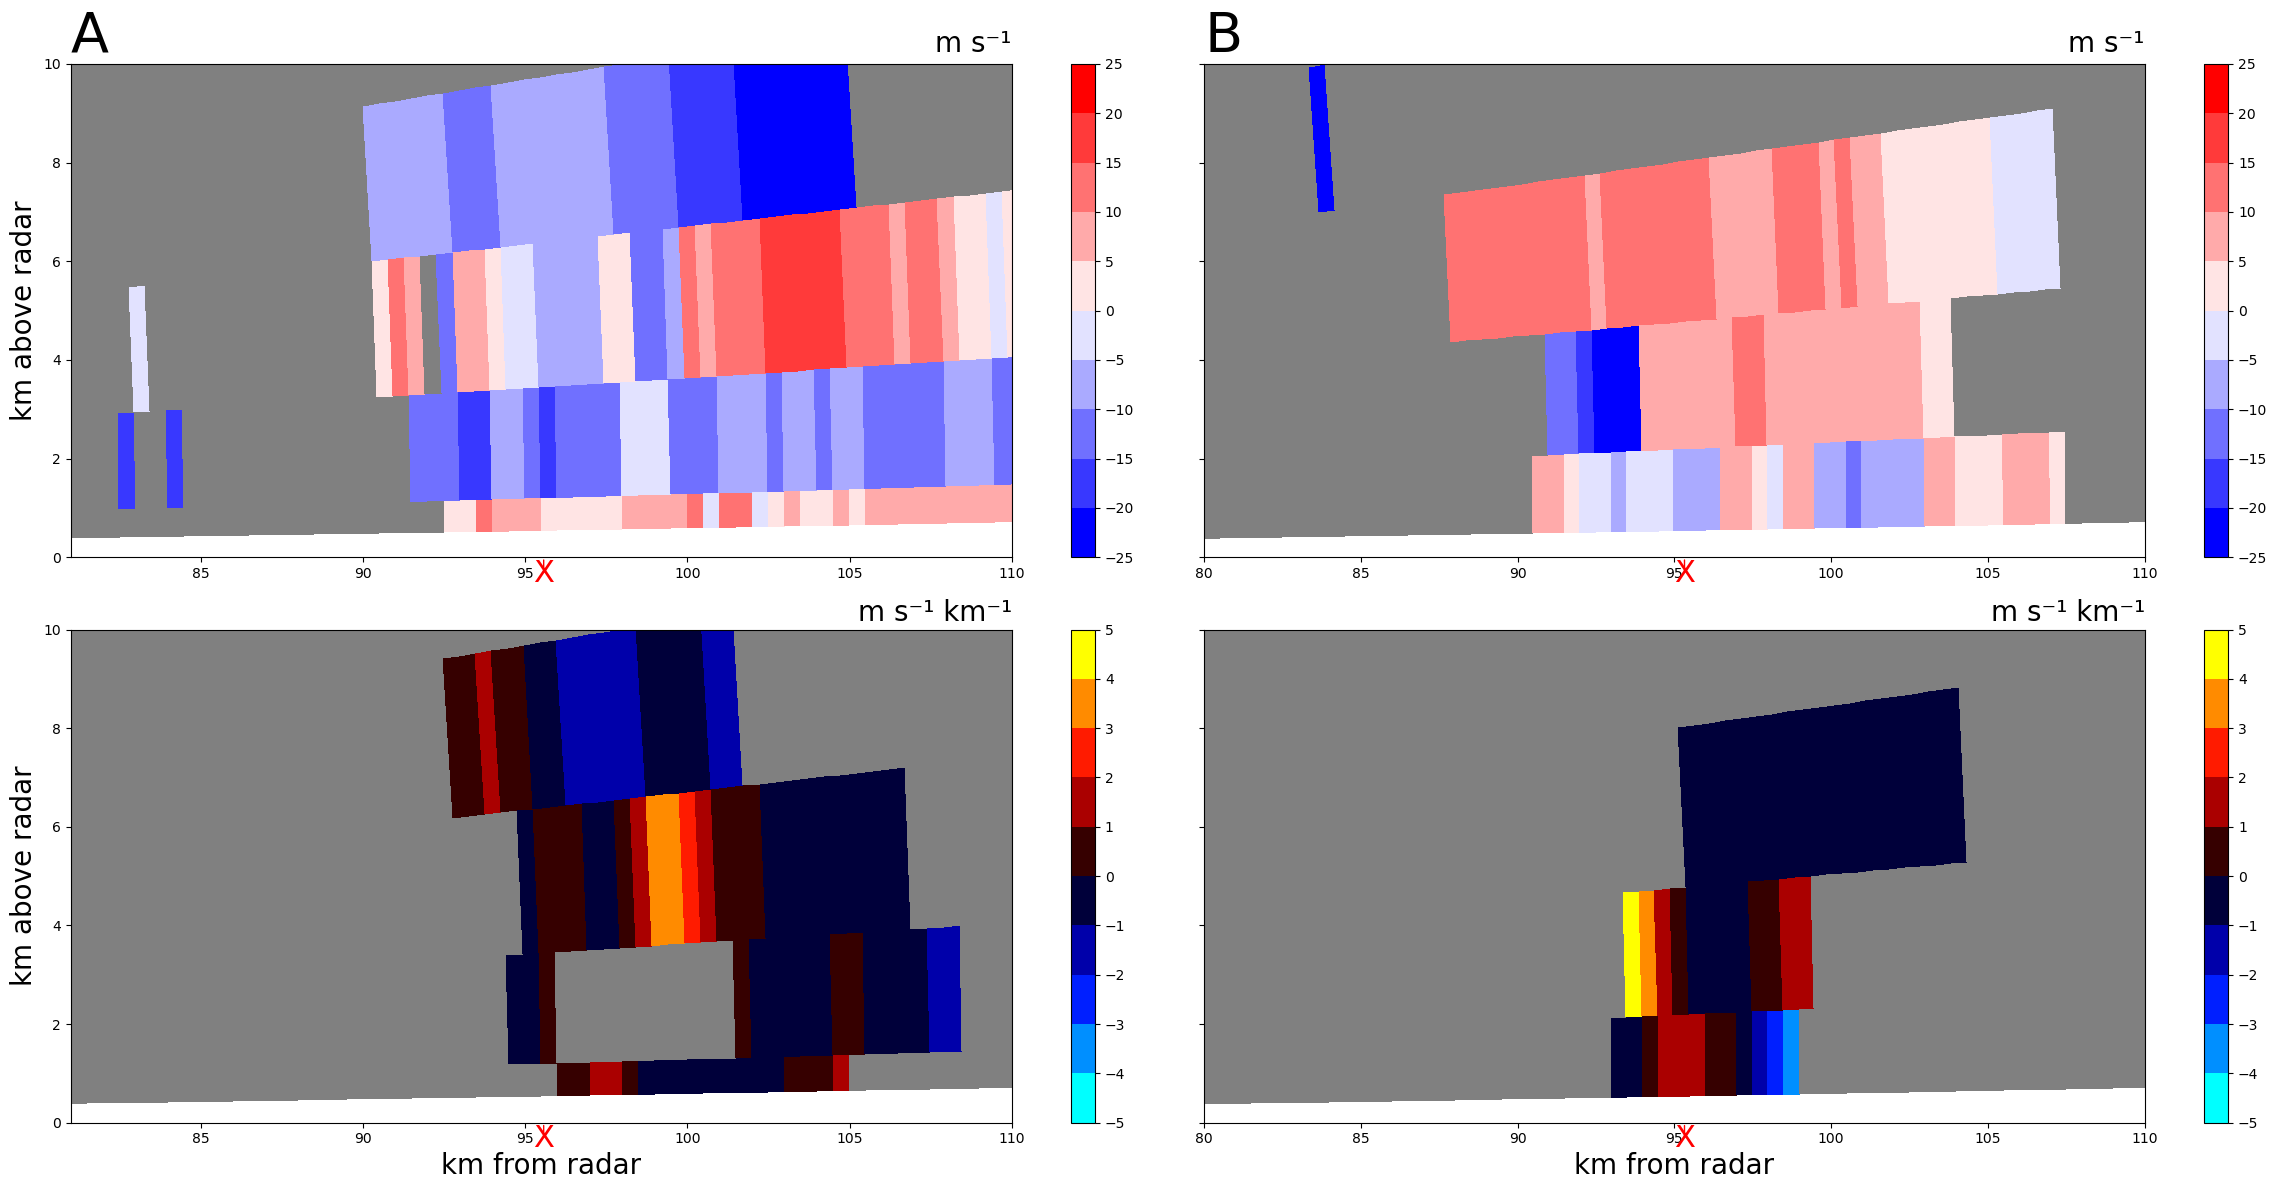

In [7]:

div_shear_norm = BoundaryNorm(boundaries=div_shear_levels, ncolors=256, clip=True)
# Define tick levels and normalization
div_shear_levels = np.arange(-5, 5.5, 1)  # Original tick locations

rhi_close_weissfluhgipfel = 81


# Set up the figure with 4 rows and 4 columns
fig, axes = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(24, 12))


ax_vel_weissfluhgipfel = axes[0, 0]  # Velocity plot
ax_vel_lema = axes[0, 1]  # Velocity plot
ax_div_shear_weissfluhgipfel = axes[1, 0]  # Divergence/Shear plot
ax_div_shear_lema = axes[1, 1]  # Divergence/Shear plot
ax_vel_weissfluhgipfel.set_xlim([rhi_close_weissfluhgipfel, rhi_distance_weissfluhgipfel])
ax_vel_lema.set_xlim([rhi_close_lema, rhi_distance_lema])
ax_div_shear_weissfluhgipfel.set_xlim([rhi_close_weissfluhgipfel, rhi_distance_weissfluhgipfel])
ax_div_shear_lema.set_xlim([rhi_close_lema, rhi_distance_lema])



# Plot 'corrected_velocity' with specified color limits
cmap_velocity.set_bad(color='grey')
display_first_scan_weissfluhgipfel.plot_rhi('corrected_velocity', ax=ax_vel_weissfluhgipfel, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity, colorbar_label='', colorbar_flag=True)

cmap_div_shear.set_bad(color='grey')
display_first_scan_weissfluhgipfel.plot_rhi('div_shear', ax=ax_div_shear_weissfluhgipfel, ticks=div_shear_levels, norm=div_shear_norm, 
#vmin=-20, vmax=70,
    cmap=cmap_div_shear, colorbar_label='', colorbar_flag=True)

# Plot 'corrected_velocity' with specified color limits
cmap_velocity.set_bad(color='grey')
display_second_scan_lema.plot_rhi('corrected_velocity', ax=ax_vel_lema, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity, colorbar_label='', colorbar_flag=True)

cmap_div_shear.set_bad(color='grey')
display_second_scan_lema.plot_rhi('div_shear', ax=ax_div_shear_lema, ticks=div_shear_levels, norm=div_shear_norm, 
#vmin=-20, vmax=70,
    cmap=cmap_div_shear, colorbar_label='', colorbar_flag=True)
        


# Annotate 'X' on the axes where needed
for axis in [ax_vel_weissfluhgipfel, ax_div_shear_weissfluhgipfel]:
    axis.annotate('X', xy=(downburst_distance_weissfluhgipfel, 0), xytext=(downburst_distance_weissfluhgipfel, -0.5),
                          textcoords='data', ha='center', color='red', fontsize=22,
                          arrowprops=dict(arrowstyle='-', color='red'))
    
# Annotate 'X' on the axes where needed
for axis in [ax_vel_lema, ax_div_shear_lema]:
    axis.annotate('X', xy=(downburst_distance_lema, 0), xytext=(downburst_distance_lema, -0.5),
                          textcoords='data', ha='center', color='red', fontsize=22,
                          arrowprops=dict(arrowstyle='-', color='red'))

# Set axis limits for each axis
ax_vel_weissfluhgipfel.set_ylim([0, 10])   # Adjust height range as needed






ax_vel_weissfluhgipfel.set_xlabel('')
ax_vel_weissfluhgipfel.set_ylabel('km above radar', fontsize=20)
ax_vel_weissfluhgipfel.set_title('')
ax_vel_weissfluhgipfel.set_title('m s⁻¹', fontsize=20, loc ='right')
ax_vel_weissfluhgipfel.set_title('A', fontsize=40, loc ='left')

ax_vel_lema.set_xlabel('')
ax_vel_lema.set_ylabel('')
ax_vel_lema.set_title('')
ax_vel_lema.set_title('m s⁻¹', fontsize=20, loc ='right')
ax_vel_lema.set_title('B', fontsize=40, loc ='left')

ax_div_shear_weissfluhgipfel.set_xlabel('')
ax_div_shear_weissfluhgipfel.set_ylabel('km above radar', fontsize=20)
ax_div_shear_weissfluhgipfel.set_title('')
ax_div_shear_weissfluhgipfel.set_title('m s⁻¹ km⁻¹', fontsize=20, loc ='right')
ax_div_shear_weissfluhgipfel.set_xlabel('km from radar', fontsize=20)

ax_div_shear_lema.set_xlabel('')
ax_div_shear_lema.set_ylabel('')
ax_div_shear_lema.set_title('')
ax_div_shear_lema.set_title('m s⁻¹ km⁻¹', fontsize=20, loc ='right')
ax_div_shear_lema.set_xlabel('km from radar', fontsize=20)

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)


plt.tight_layout()
#plt.savefig("/users/fackerma/newproject1/figures/sixth_case/double_RHI_LCDF_LCDFCS1.png", dpi=300)

## Crowd-Sourcing Data

valid_time3: 10:10
valid_time: 2023-07-24 08:10:00


/tmp/ipykernel_219237/3680018441.py:63: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ms / 1000)


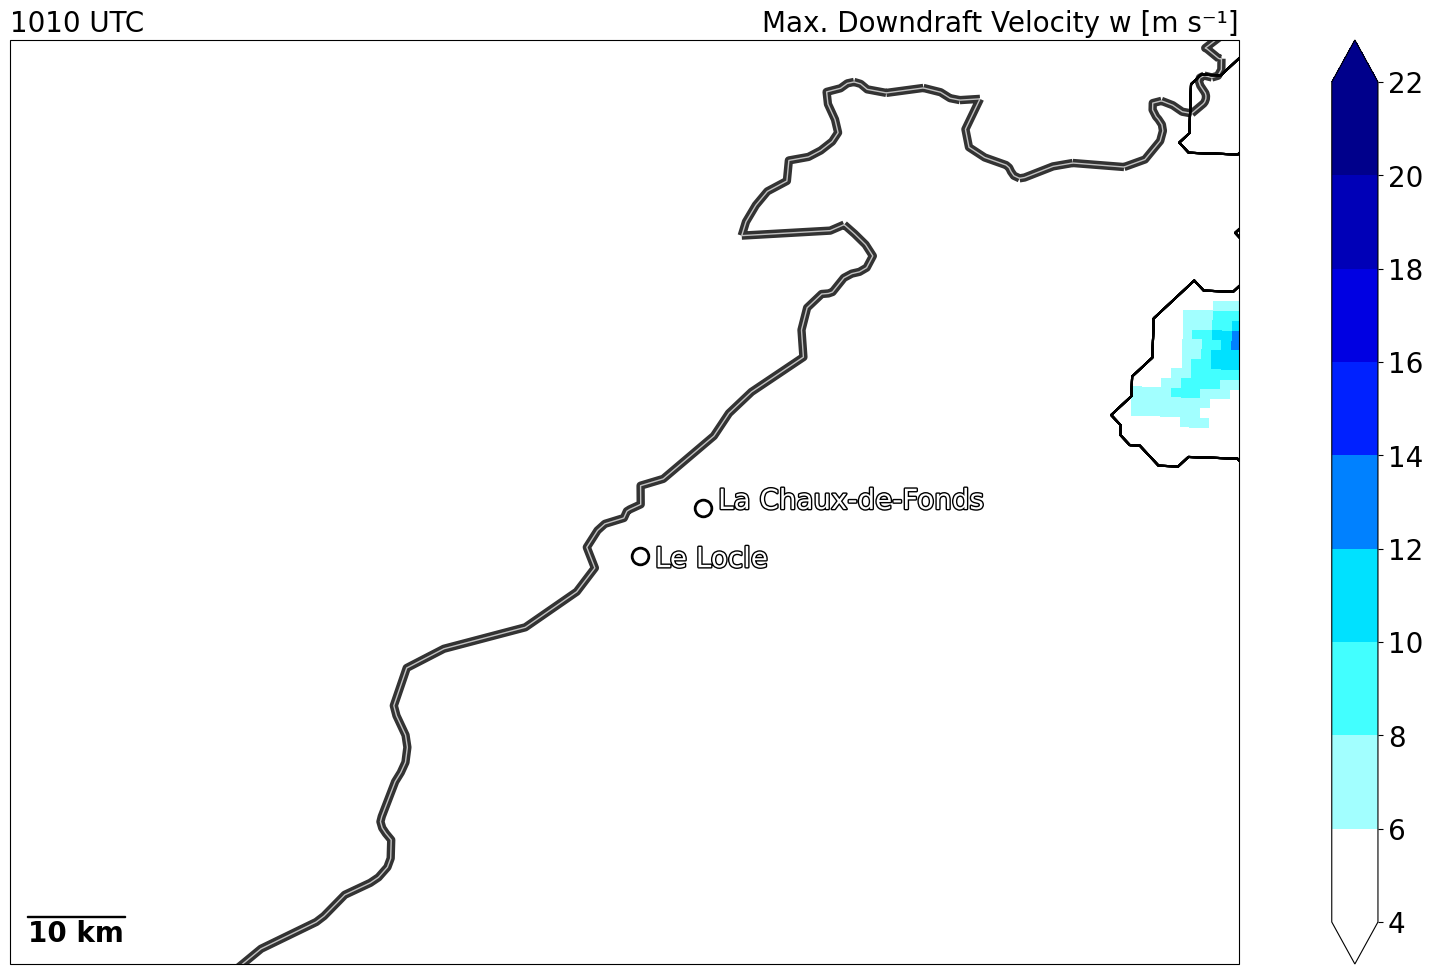

In [87]:
# Crowd-sourcing data and Max. downdraft estimator w
# Multi-variable plot
projection = ccrs.epsg(3035)
# Create figure with three subplots (Reflectivity, Velocity, and Dealiased Velocity)
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': projection})


# St. Gallen 1900
downburst_location = 'La Chaux-de-Fonds'
downburst_lat = LaChauxDeFonds_lat
downburst_lon = LaChauxDeFonds_lon

fig.patch.set_facecolor('white')  # Set figure background
ax.set_facecolor('white')  # Set axis background
edgecolor = 'black'


# Plot wge composite
# Set a mask
wge = np.ma.masked_less_equal(wge, 0)
cmap_wge.set_bad(color='grey')
p12 = ax.pcolormesh(clons, clats, wge, #vmin=0, vmax=18, 
                   cmap=cmap_wge, transform=projection, norm=wge_norm)
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=ax, extend='both', cmap=cmap_wge, norm=wge_norm, boundaries=wge_levels, ticks=wge_levels
                     )
cbar12.outline.set_edgecolor(edgecolor)
cbar12.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color=edgecolor, fontsize = 20)
ax.set_title('Max. Downdraft Velocity w [m s⁻¹]', color=edgecolor, loc='right', fontsize=20)
ax.set_title(valid_time3 + ' UTC', color=edgecolor, loc='left', fontsize=20)

ax.set_extent([downburst_lon - 0.9, downburst_lon + 0.7, downburst_lat -0.4, downburst_lat + 0.4], crs=ccrs.PlateCarree())
 # Add borders, coastlines, and lakes with custom contour lines
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=6)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
ax.plot(LaChauxDeFonds_lon, LaChauxDeFonds_lat, marker='o', color='white', markersize=12, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree()) 
ax.plot(LeLocle_lon, LeLocle_lat, marker='o', color='white', markersize=12, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree()) 
LaChauxDeFonds_text = ax.text(LaChauxDeFonds_lon + 0.02, LaChauxDeFonds_lat, 'La Chaux-de-Fonds', color='white', fontsize=20, transform=ccrs.PlateCarree())
LeLocle_text = ax.text(LeLocle_lon + 0.02, LeLocle_lat-0.01, 'Le Locle', color='white', fontsize=20, transform=ccrs.PlateCarree())
LaChauxDeFonds_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
LeLocle_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        

ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), colors='black', alpha=1, transform=ccrs.PlateCarree())
#ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), colors='lime', linestye='dotted', alpha=0.5, transform=ccrs.PlateCarree())






# Load the JSON file
with open(file_cs, 'r') as file:
    data = json.load(file)

# Convert timestamp to datetime
def convert_timestamp(ms):
    return datetime.utcfromtimestamp(ms / 1000)



valid_time3_with_colon = f"{valid_time3[:2]}:{valid_time3[2:]}"  # Add colon to valid_time3

# Convert valid_time3 to a datetime object
valid_time3_datetime = datetime.strptime(f'2023-07-24 {valid_time3_with_colon}', '%Y-%m-%d %H:%M')

# Calculate valid_time as 2 hours before valid_time3
valid_time = valid_time3_datetime - timedelta(hours=2)

# Format valid_time as a string with the desired format
valid_time_str = valid_time.strftime('%Y-%m-%d %H:%M:%S')

print(f"valid_time3: {valid_time3_with_colon}")
print(f"valid_time: {valid_time_str}")




# Set the valid time and time range
time_range = timedelta(minutes=2.5)

# Filter features within the time range
filtered_features = [
    feature for feature in data
    if abs(convert_timestamp(feature['properties']['timestamp']) - valid_time) <= time_range
]

# Plot the features
for feature in filtered_features:
    lon, lat = feature['geometry']['coordinates']
    ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=10)





# Define the size of the size bar (in map units, e.g., meters)
size_bar_length = 10000  # 10 km in meters (adjust as needed)
size_bar_text = '10 km'  # Text to display next to the size bar

# Create the size bar font
size_bar_font = fm.FontProperties(size=20, weight='bold')

# Add size bar to the second plot
size_bar_ax2 = AnchoredSizeBar(
    ax.transData,  # Transformation for positioning
    size_bar_length,    # Length of the size bar
    size_bar_text,      # Label for the size bar
    loc='lower left',   # Location on the plot
    pad=0.5,            # Padding around the bar
    color='black',      # Color of the size bar
    frameon=False,      # No frame around the bar
    size_vertical=50,   # Thickness of the bar
    fontproperties=size_bar_font  # Font properties for the label
)
ax.add_artist(size_bar_ax2)  # Add the size bar to the second axis

# Save the figure
#plt.savefig("/users/fackerma/newproject1/figures/sixth_case/CS2/CS2_" + valid_time3 + ".png", dpi=300)

7.032715905235111 47.031956762707004
6.83989762 47.11231874
6.835270764440607 47.10546219341157
6.84 47.105
6.824997818375689 47.100209539033
6.824997818375689 47.100209539033
6.824997818375689 47.100209539033
6.8322011 47.1029931
6.924733286373281 46.39578112699583
6.894693374633789 47.12077128700912
8.620000186587243 47.1335102871271
6.8323547 47.1028293
6.824997818375689 47.100209539033


/tmp/ipykernel_146591/1654989530.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ms / 1000)


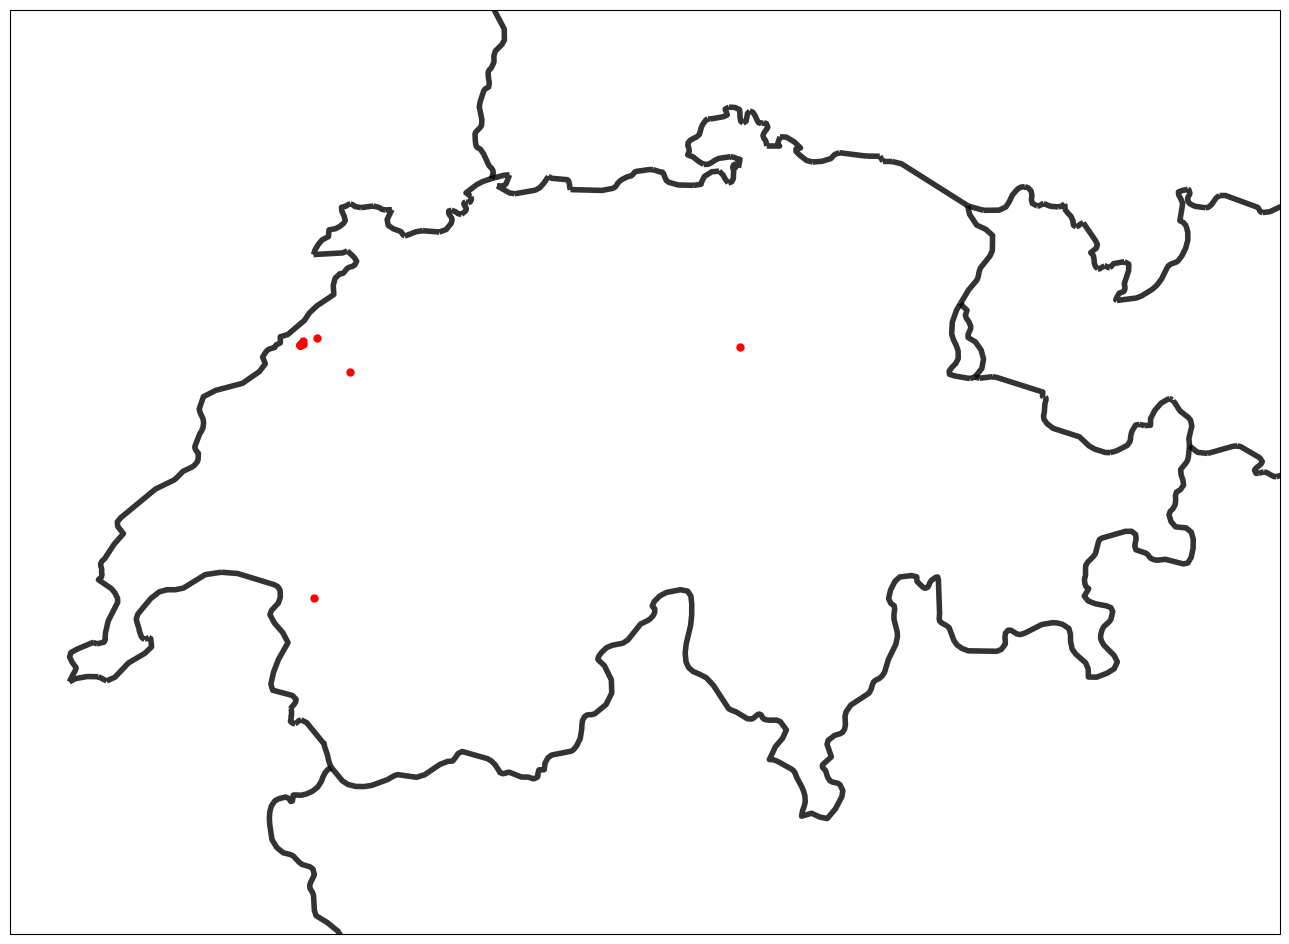

In [7]:



# Load the JSON file
with open(file_cs, 'r') as file:
    data = json.load(file)

# Convert timestamp to datetime
def convert_timestamp(ms):
    return datetime.utcfromtimestamp(ms / 1000)

# Set the valid time and time range
valid_time = datetime.strptime('2023-07-24 07:30:00', '%Y-%m-%d %H:%M:%S')
time_range = timedelta(minutes=2.5)

# Filter features within the time range
filtered_features = [
    feature for feature in data
    if abs(convert_timestamp(feature['properties']['timestamp']) - valid_time) <= time_range
]

# Set up the plot (assuming you've already created the figure and axis)
projection = ccrs.epsg(3035)
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': projection})

# Plot the features
for feature in filtered_features:
    lon, lat = feature['geometry']['coordinates']
    ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=5)
    print(lon, lat)

# Add coastlines and borders for reference
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=4)

# Set the extent of the map (adjust as needed)
ax.set_extent(extent_switzerland, crs=ccrs.PlateCarree())




